# 02 DurationMatching : 02 Volatile : ALL

---
## 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')

import seaborn as sns

import sys
sys.path.append('../../RLPack')

import importlib
import itertools

---
## 1. Environment

In [2]:
import Env_DM
importlib.reload(Env_DM)

yield_curve = np.arange(11).reshape(-1, 1)/100 * np.ones(10).reshape(1, -1)
liability_CF = np.zeros(10)
liability_CF[-1] += -10

env = Env_DM.Environment(yield_curve, liability_CF)

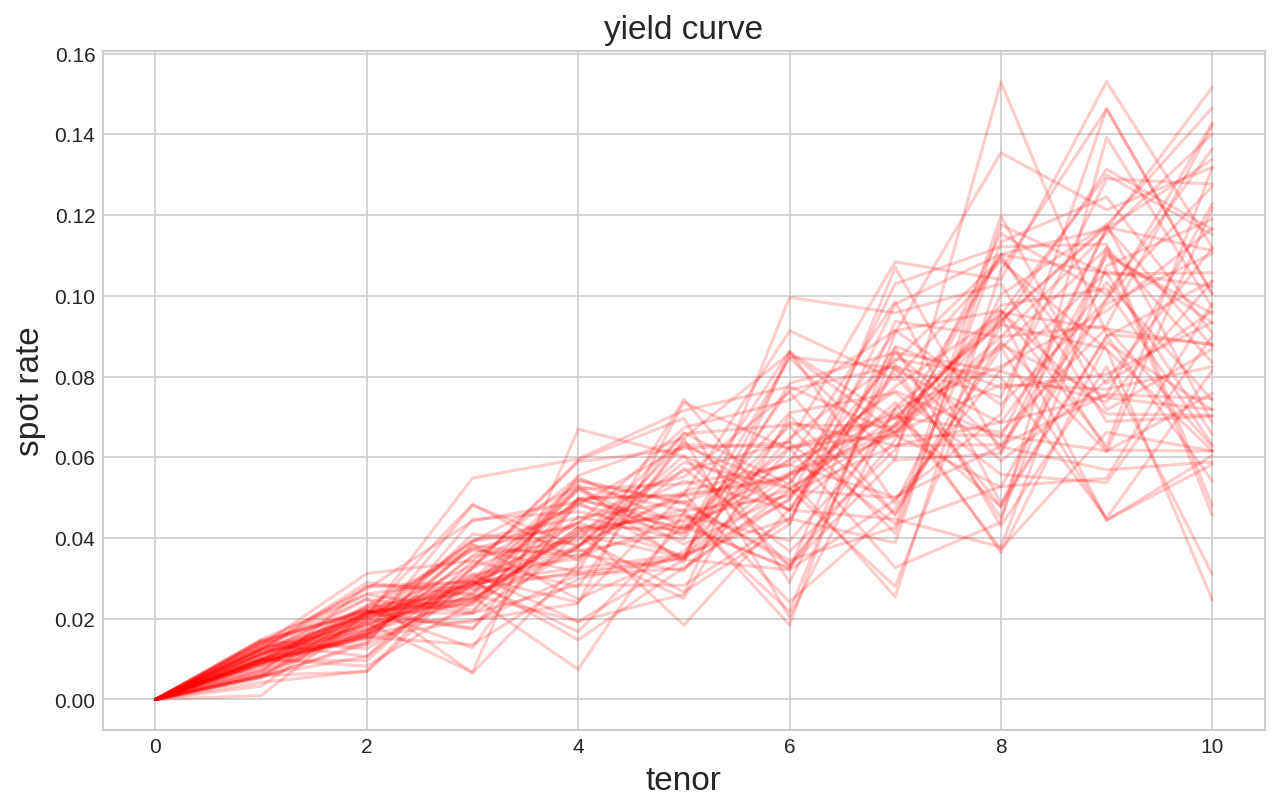

In [3]:
yield_vol = 0.3
env = Env_DM.Environment(yield_curve, liability_CF, 
                        gen_yield_on_reset=True, yield_vol=yield_vol)
fig = plt.figure(figsize=(10, 6), dpi=150)
plt.plot(env.yield_curve[:, :, 0].T, c='r', alpha=0.2)
plt.title('yield curve', size=16)
plt.xlabel('tenor', size=16)
plt.ylabel('spot rate', size=16)
plt.show()

---
## 2. Volatile

In [4]:
env = Env_DM.Environment(yield_curve, liability_CF,
                         gen_yield_on_reset=True, yield_vol=yield_vol, 
                         reset_cash=False)

n_trials = 5
n_steps = 10000

df = pd.DataFrame()

/home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
W1030 23:06:27.284775 140344548288320 deprecation_wrapper.py:119] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1030 23:06:27.285449 140344548288320 deprecation_wrapper.py:119] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1030 23:06:27.288771 

lr=0.001, eps=0.1, boltzmann=True
start testing... :  2019-10-30 23:06:27.362161
start trial 1/5 trial...


W1030 23:06:27.700409 140344548288320 deprecation_wrapper.py:119] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

  0%|          | 0/10000 [00:00<?, ?it/s]

start trial 2/5 trial...


100%|██████████| 10000/10000 [01:33<00:00, 106.44it/s]


start trial 3/5 trial...


100%|██████████| 10000/10000 [01:36<00:00, 103.35it/s]


start trial 4/5 trial...


100%|██████████| 10000/10000 [01:39<00:00, 100.28it/s]


start trial 5/5 trial...


100%|██████████| 10000/10000 [01:42<00:00, 97.74it/s]


end testing... :  2019-10-30 23:14:33.952202
loss and reward history


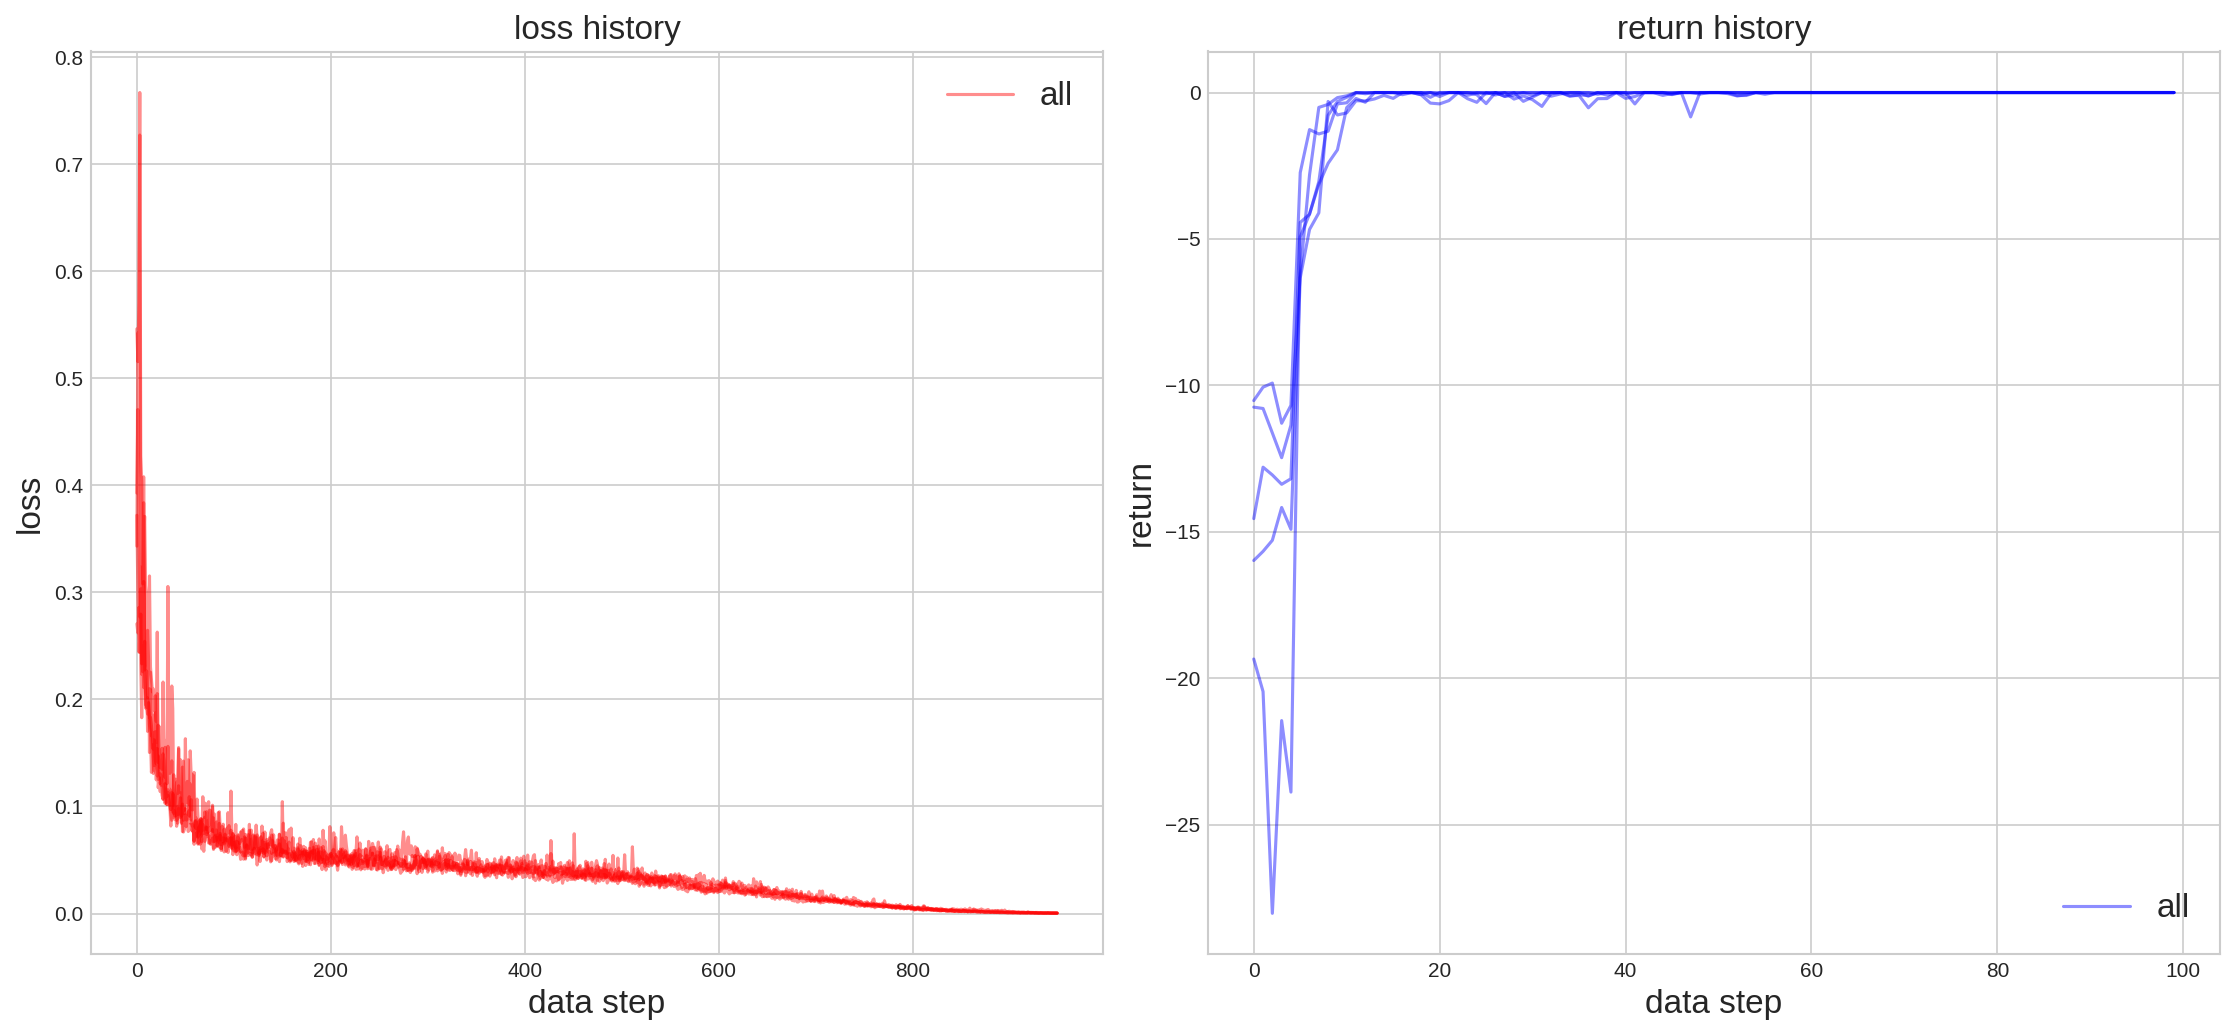

acquired action
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [9 9 9 9 9 9 9 9 9 9]
action =  [8 8 8 8 8 8 8 8 8 8]
action =  [7 7 7 7 7 7 7 7 7 7]
action =  [6 6 6 6 6 6 6 6 6 6]
action =  [5 5 5 5 5 5 5 5 5 5]
action =  [4 4 4 4 4 4 4 4 4 4]
action =  [3 3 3 3 3 3 3 3 3 3]
action =  [2 2 2 2 2 2 2 2 2 2]
action =  [1 1 1 1 1 1 1 1 1 1]
return [-1.243e-14 -1.243e-14 -2.309e-14 -1.421e-14 -1.599e-14 -1.599e-14
 -1.243e-14 -1.066e-14 -1.421e-14 -1.421e-14]
param distribution in model


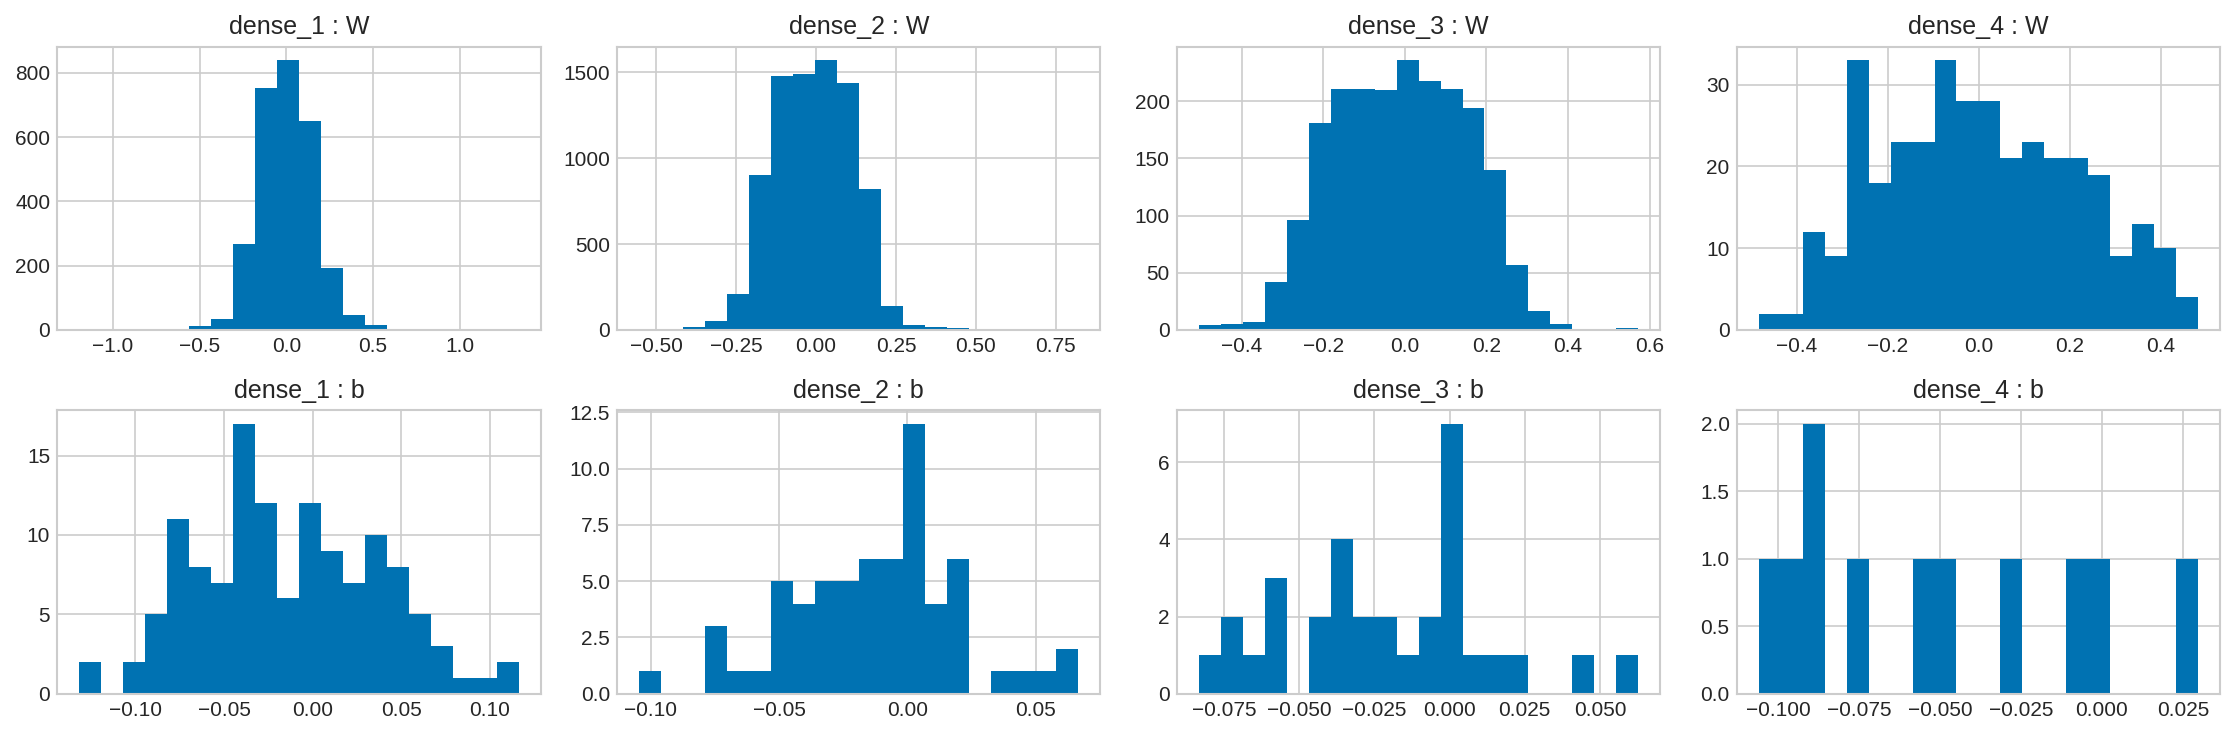

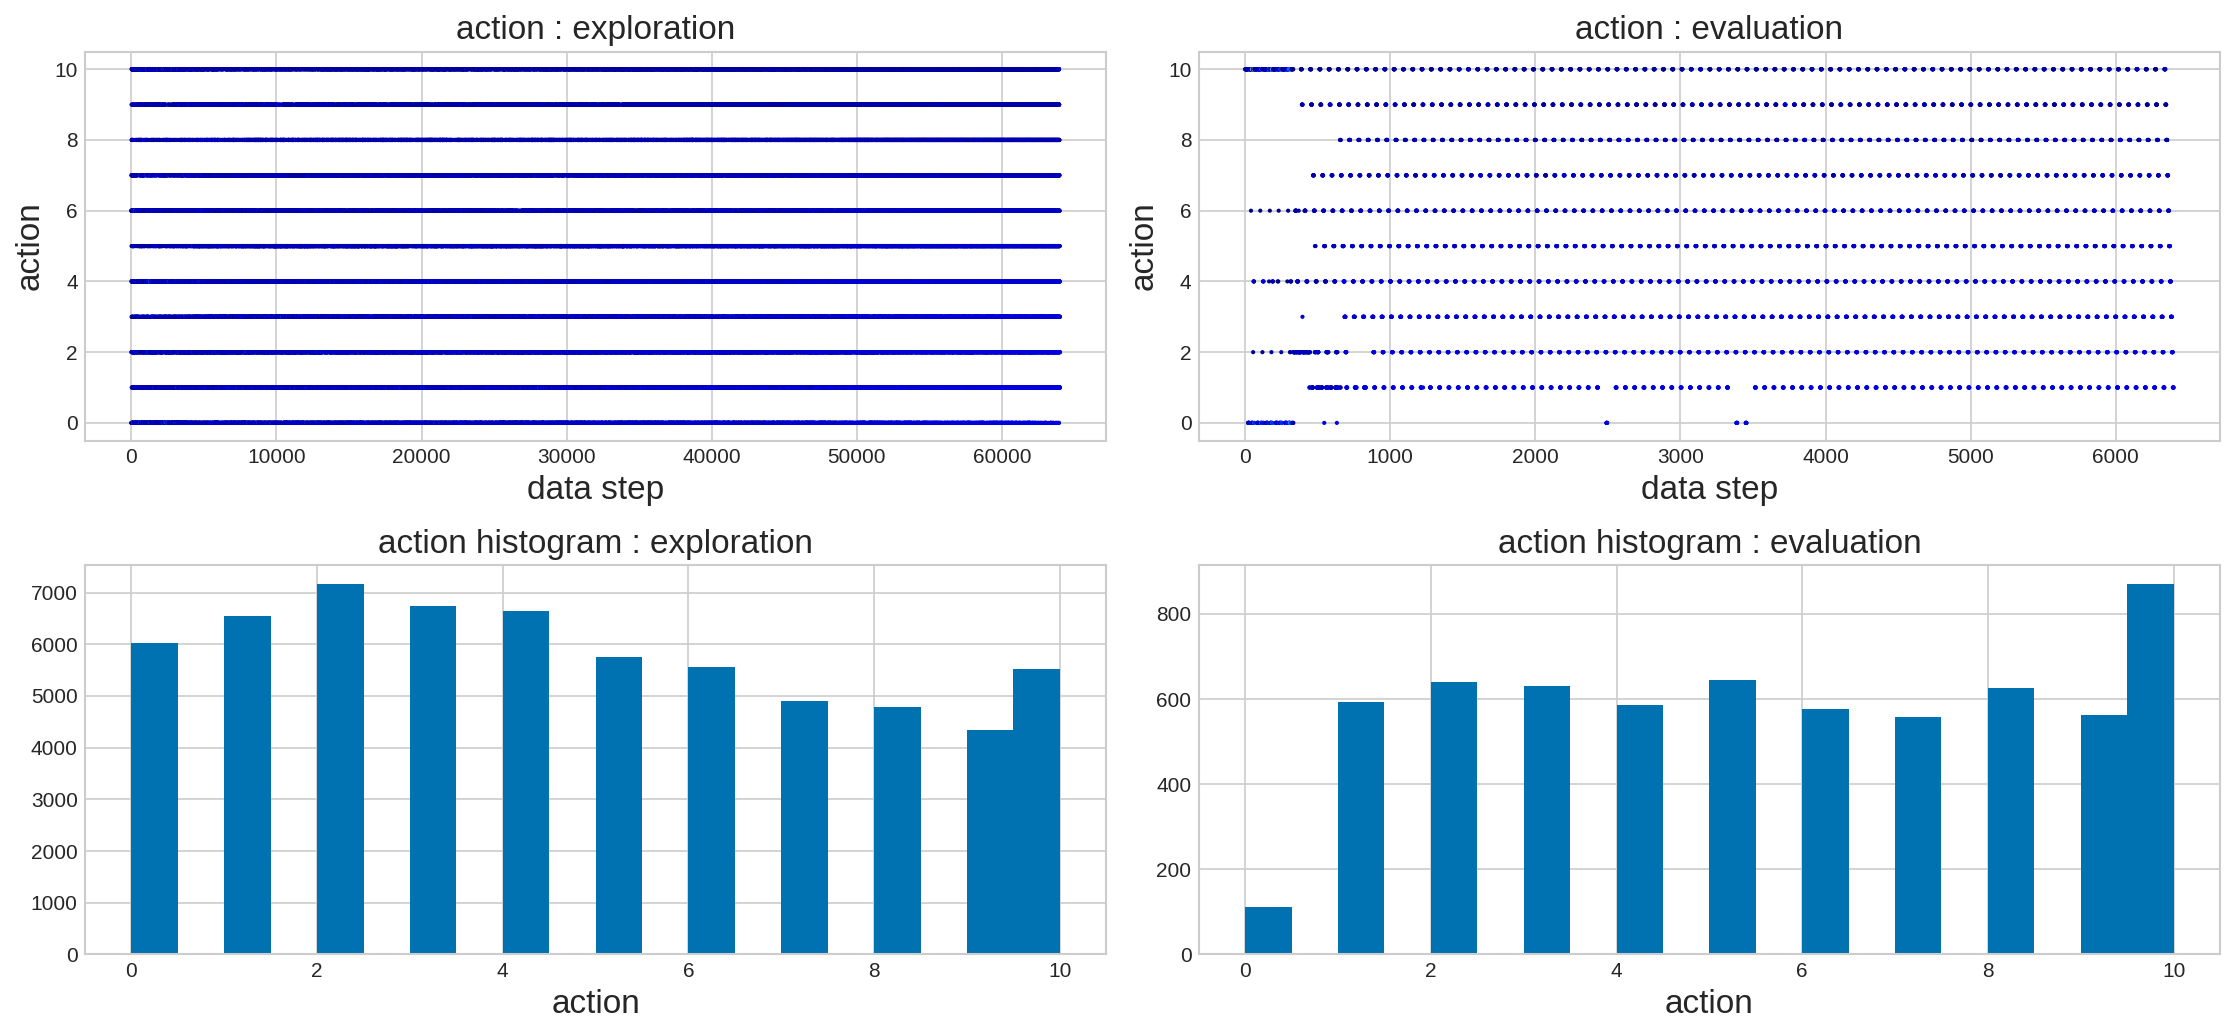

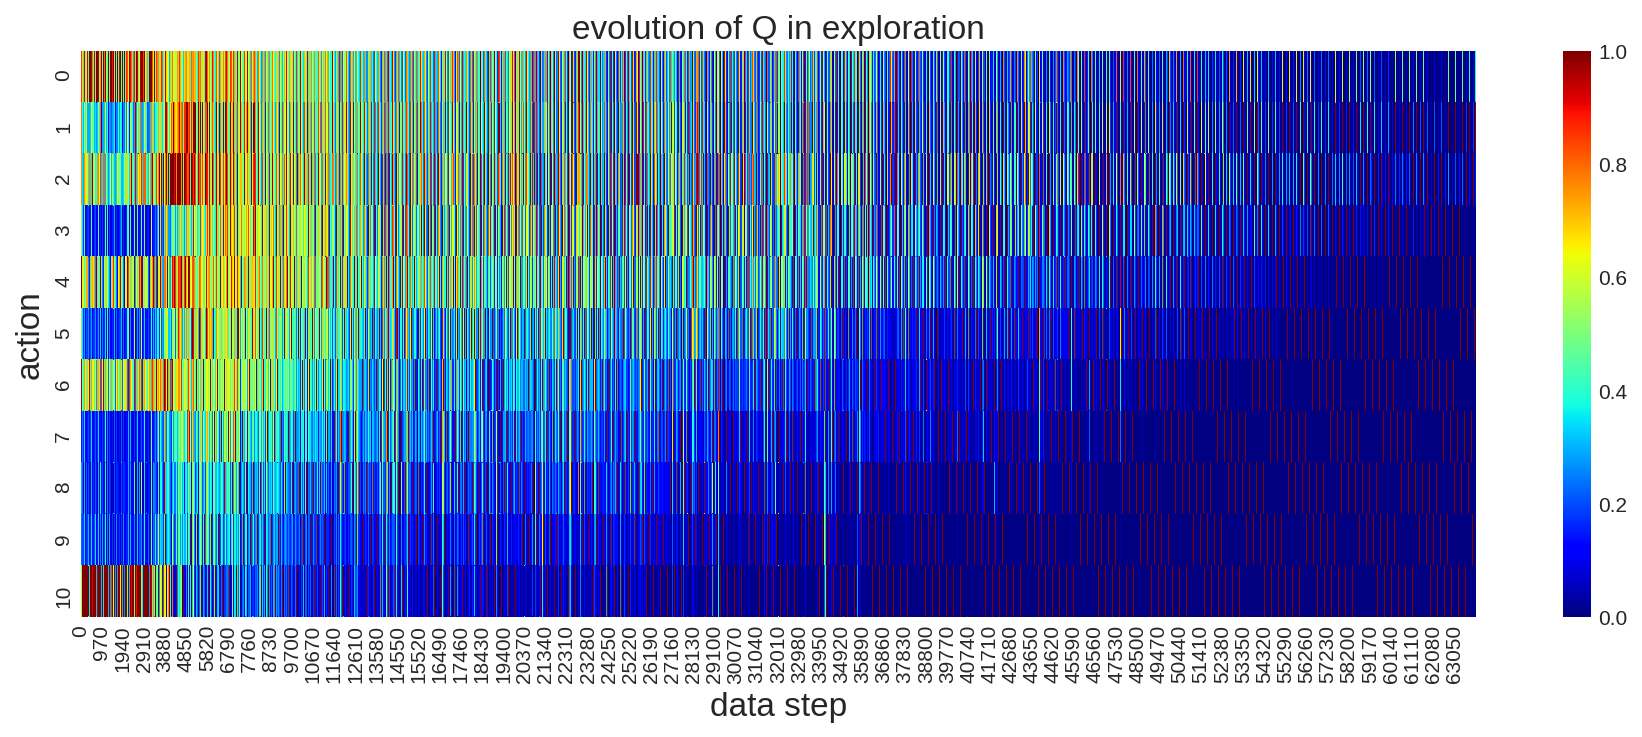

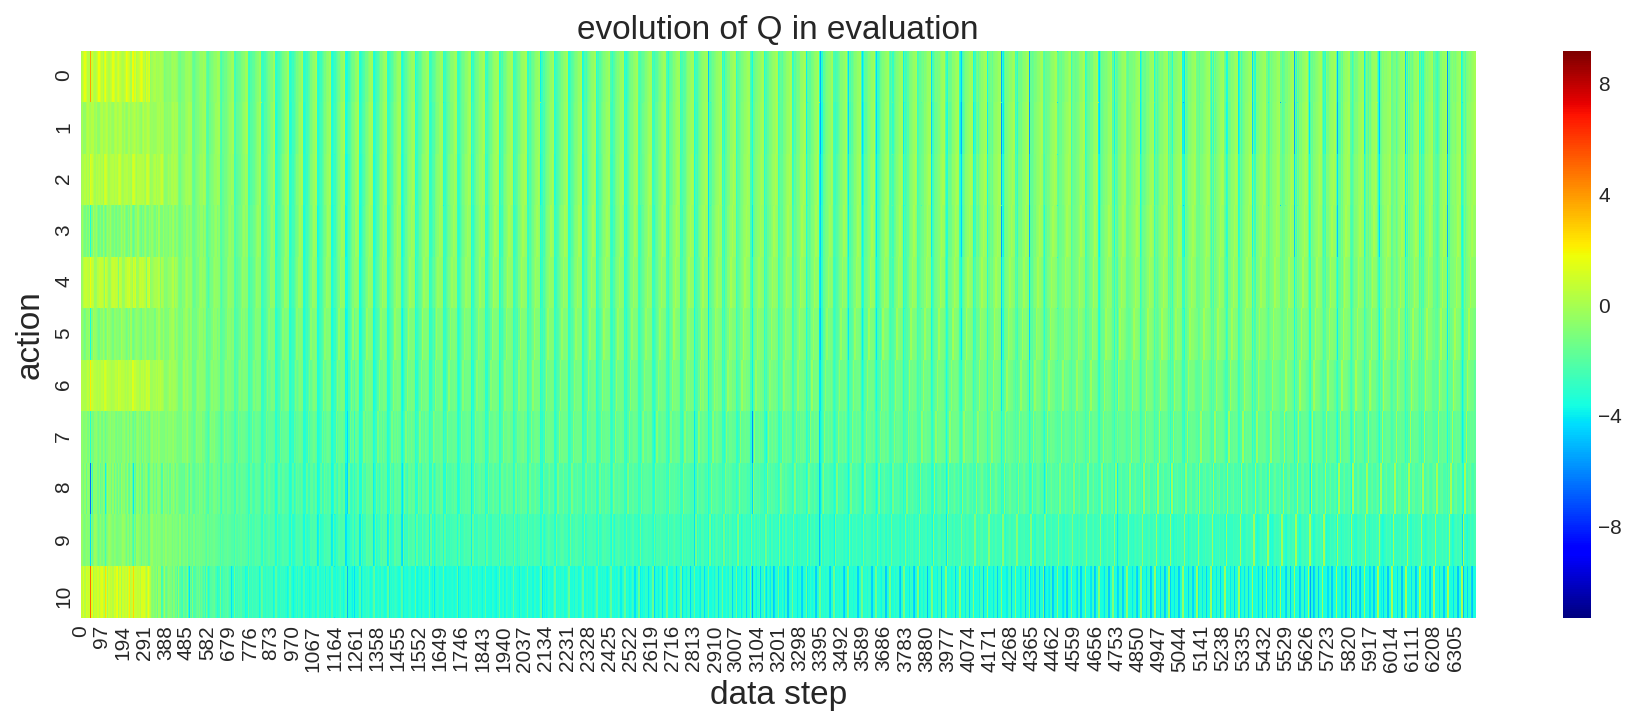

In [5]:
import DQN
import importlib
importlib.reload(DQN)  # original DRL code
from keras import optimizers

model = DQN.gen_model(input_shapes=env.shapes(), n_outputs=11, \
                           hidden_dims=[128, 64, 32], reg_l1=0.0, reg_l2=0.0, 
                           duel=False, duel_value_dim=8, duel_advantage_dim=16, 
                           input_reg=False, input_min=0, input_max=1,
                           output_reg=False, output_min=0, output_max=1)

#df = pd.DataFrame()
for lr, eps, boltzmann in itertools.product([1e-3,], [1e-1,], [True,]):
    print('======================================================')
    print('lr={}, eps={}, boltzmann={}'
          .format(lr, eps, boltzmann))
    
    tester = DQN.Tester(env, model)
    #n_trials = 5
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_steps=n_steps,
                training_interval=10, n_batches=10, batch_size=256, alpha=1.0, 
                target_update_interval=20, doubleQ=False,
                gamma=1.0, optimizer=optimizers.Adam(lr),
                epsilon_start=1.0, epsilon_end=eps, epsilon_interval=n_steps,
                boltzmann=boltzmann, 
                verbose=False, verbose_interval=100, evaluate_interval=100, 
                get_log=True)

    viz = DQN.Visualizer()
    viz.viz_action_history(tester.trainer, lambda x:x[0], 
                           cmap='jet', alpha=1.0, s=1.0)
    viz.viz_Q_history(tester.trainer)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #df_temp['eps'] = eps
        #df_temp['boltzmann'] = boltzmann
        df_temp['Agent'] = 'DQN'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

lr=0.001, n_advantages=4, mult_critic=0.1, mult_entropy=0.1
start testing... :  2019-10-30 23:14:41.776162
start 0/5 th trial...


100%|██████████| 10000/10000 [00:44<00:00, 226.57it/s]


start 1/5 th trial...


100%|██████████| 10000/10000 [00:45<00:00, 220.60it/s]


start 2/5 th trial...


100%|██████████| 10000/10000 [00:46<00:00, 215.87it/s]


start 3/5 th trial...


100%|██████████| 10000/10000 [00:47<00:00, 210.80it/s]


start 4/5 th trial...


100%|██████████| 10000/10000 [00:48<00:00, 207.08it/s]


end testing... :  2019-10-30 23:18:36.538725
loss and reward history


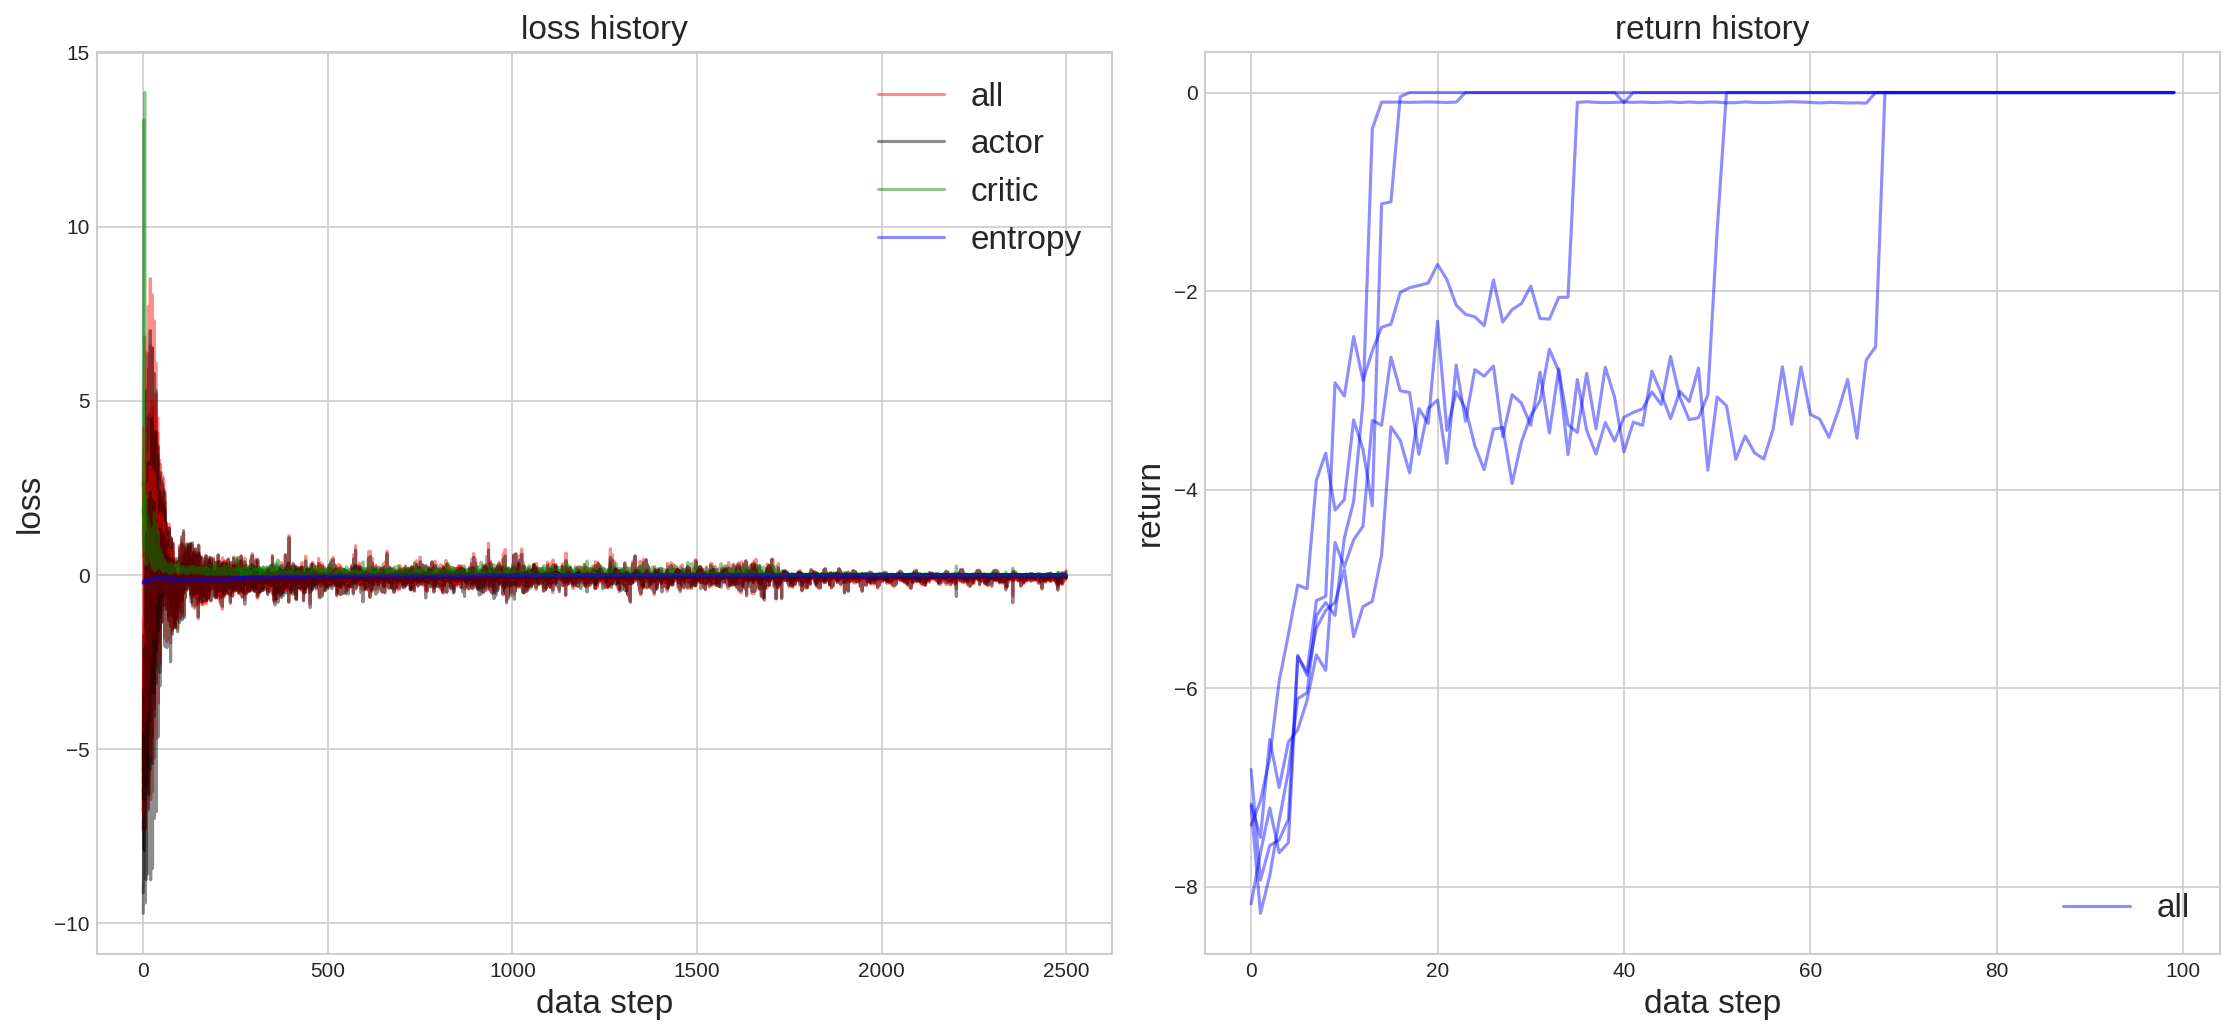

acquired action
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [9 9 9 9 9 9 9 9 9 9]
action =  [8 8 8 8 8 8 8 8 8 8]
action =  [7 7 7 7 7 7 7 7 7 7]
action =  [6 6 6 6 6 6 6 6 6 6]
action =  [5 5 5 5 5 5 5 5 5 5]
action =  [4 4 4 4 4 4 4 4 4 4]
action =  [3 3 3 3 3 3 3 3 3 3]
action =  [2 2 2 2 2 2 2 2 2 2]
action =  [1 1 1 1 1 1 1 1 1 1]
return [-1.599e-14 -1.954e-14 -1.421e-14 -1.421e-14 -1.421e-14 -2.398e-14
 -1.599e-14 -1.776e-14 -1.776e-14 -1.776e-14]
param distribution in model


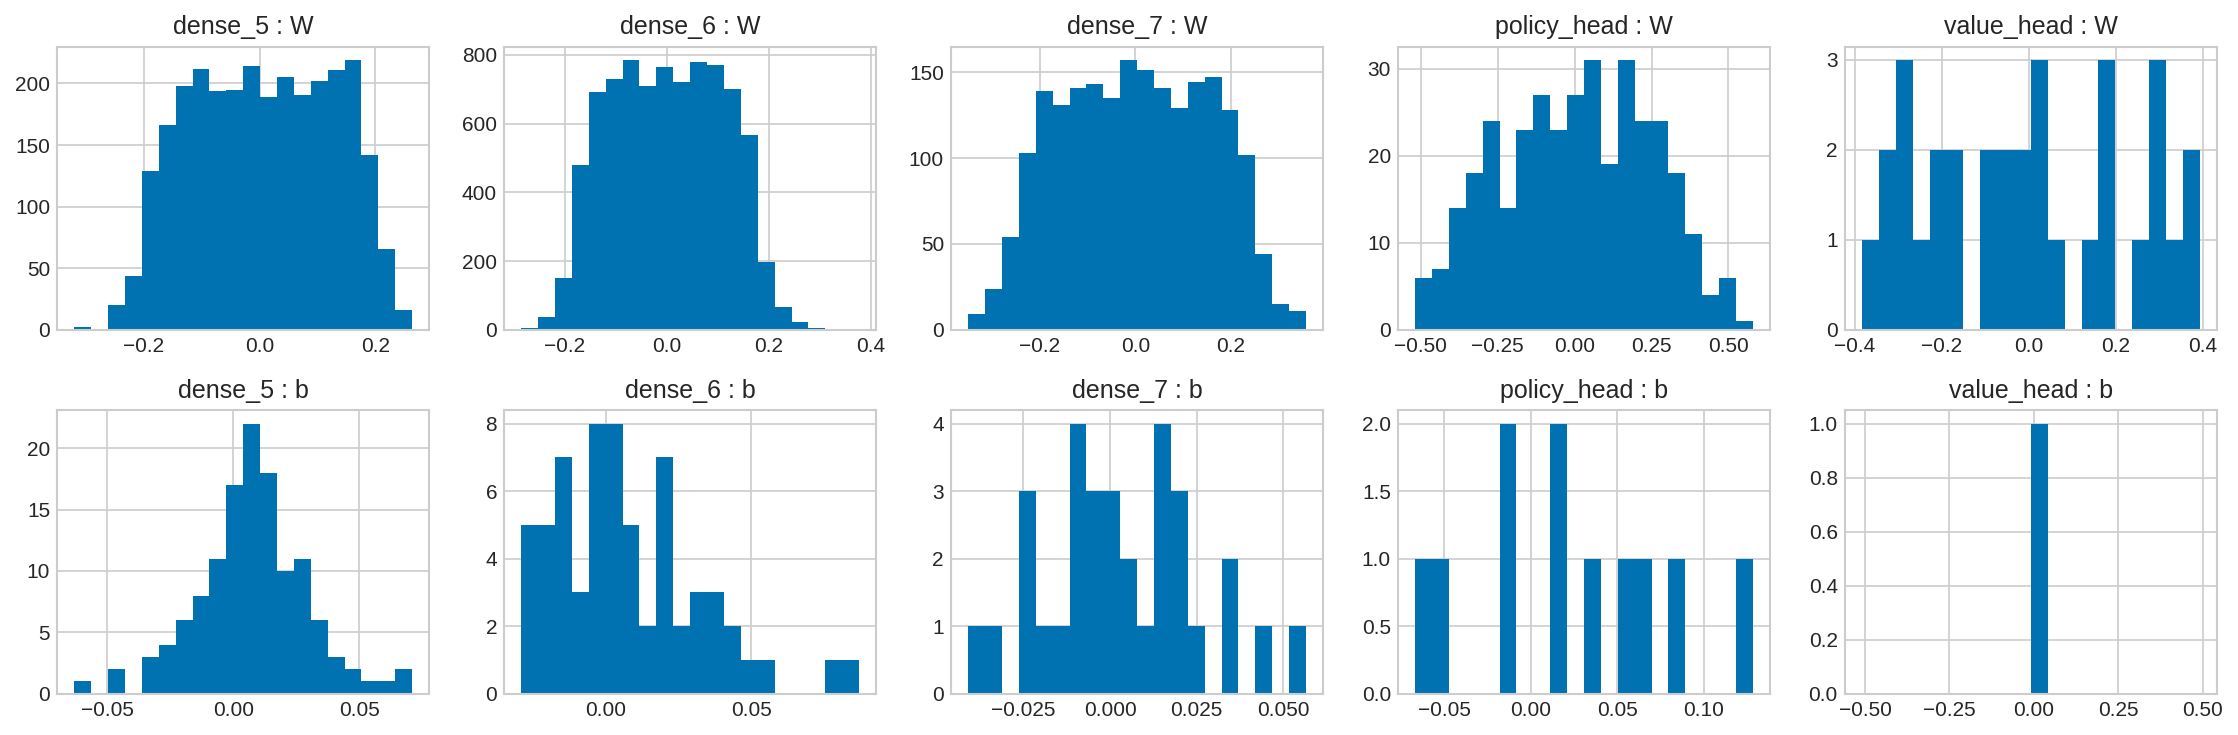

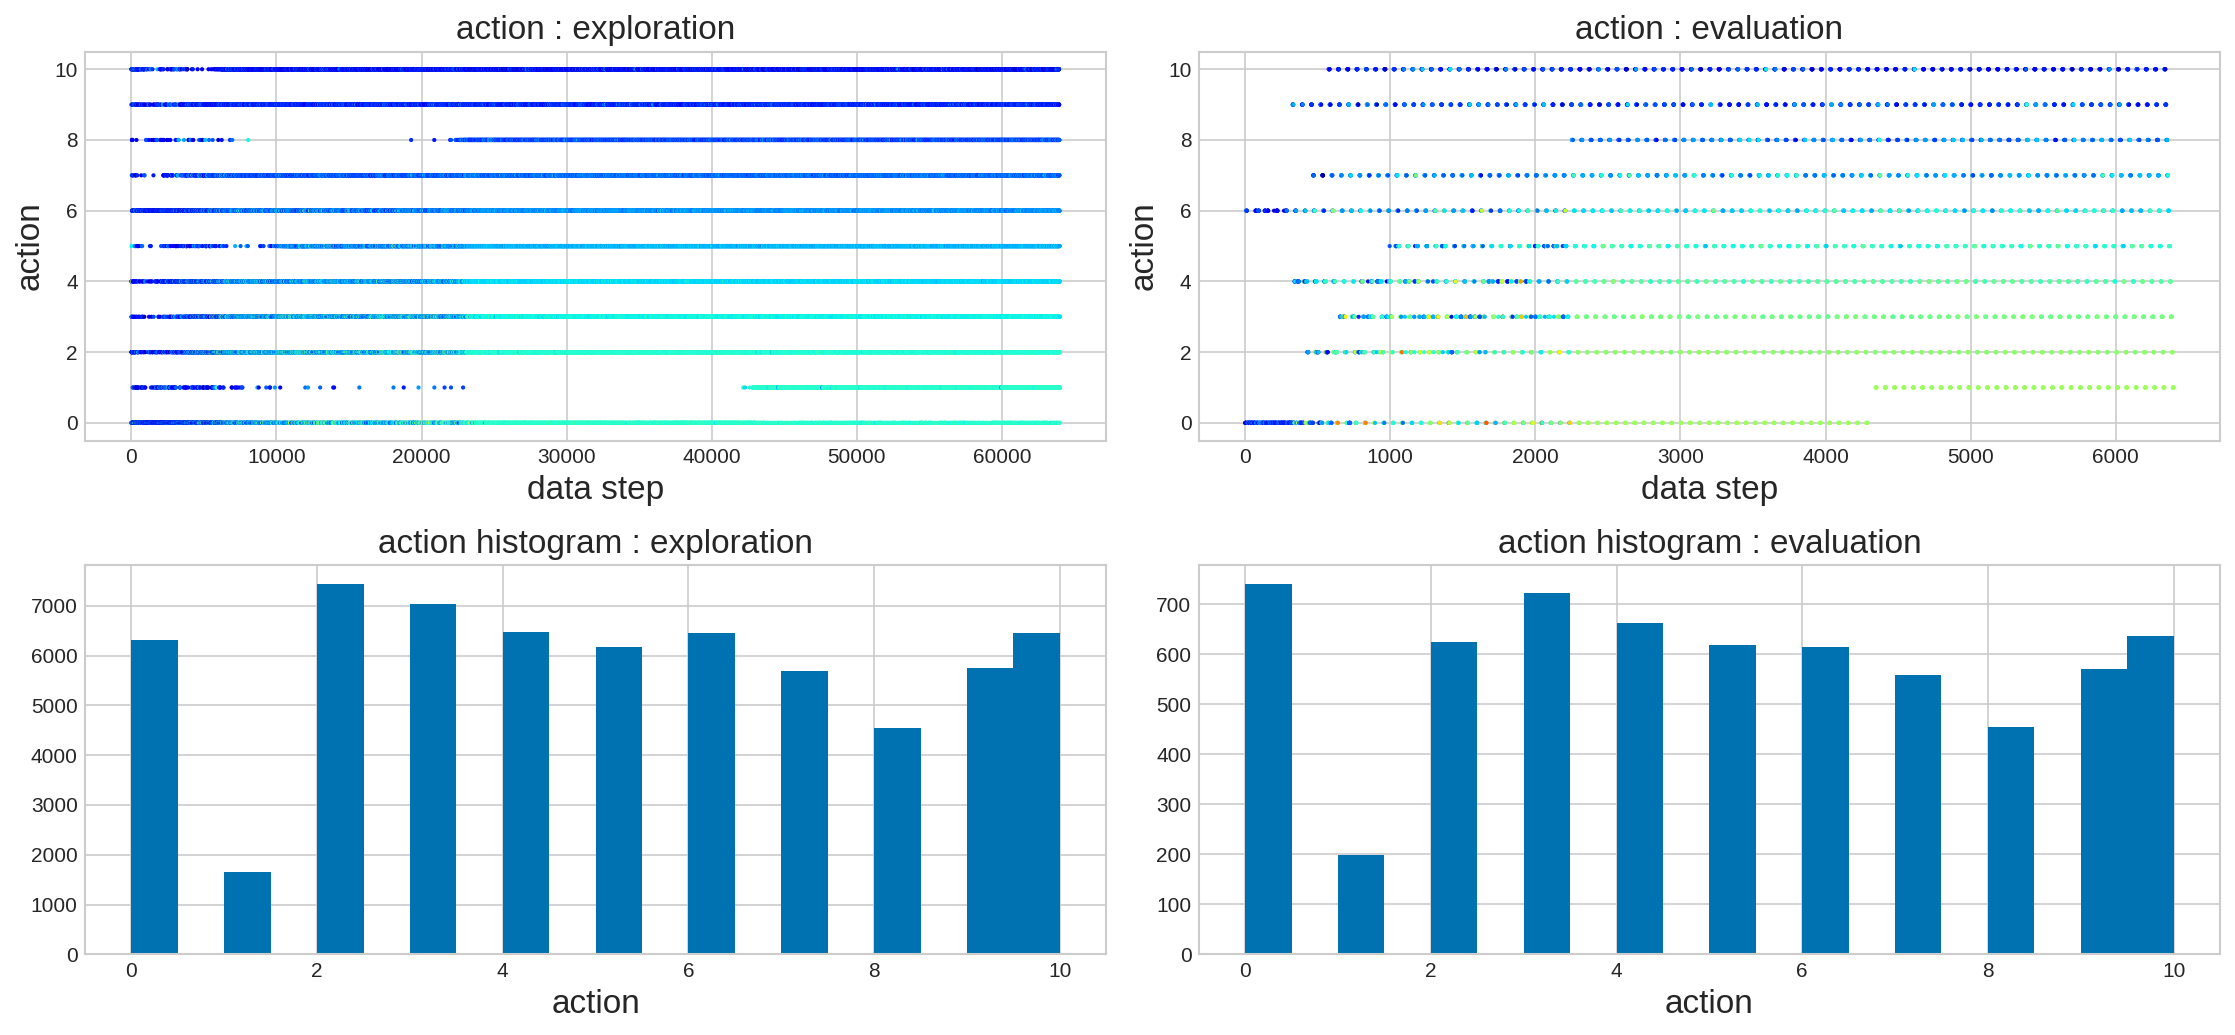

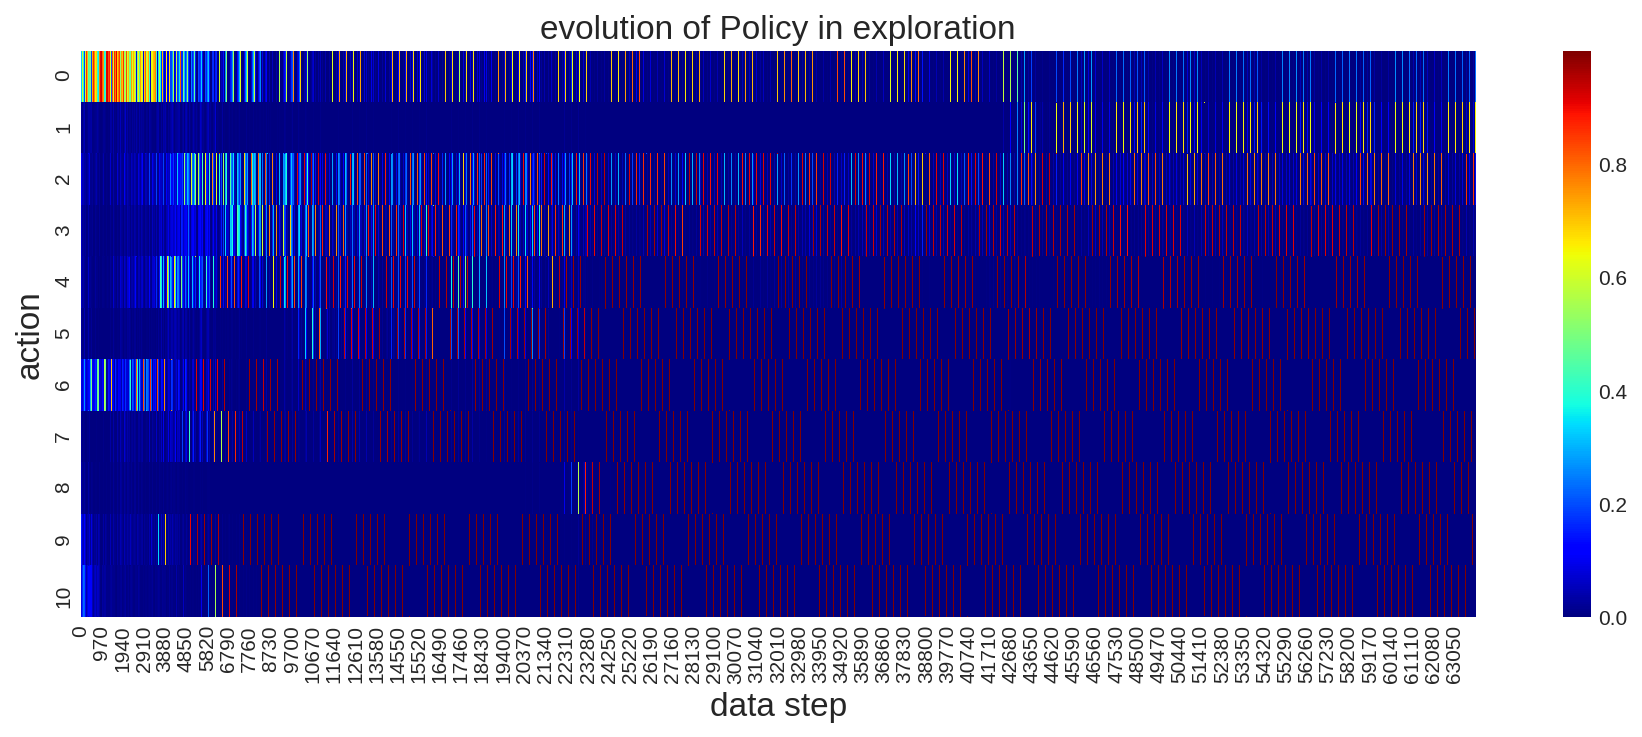

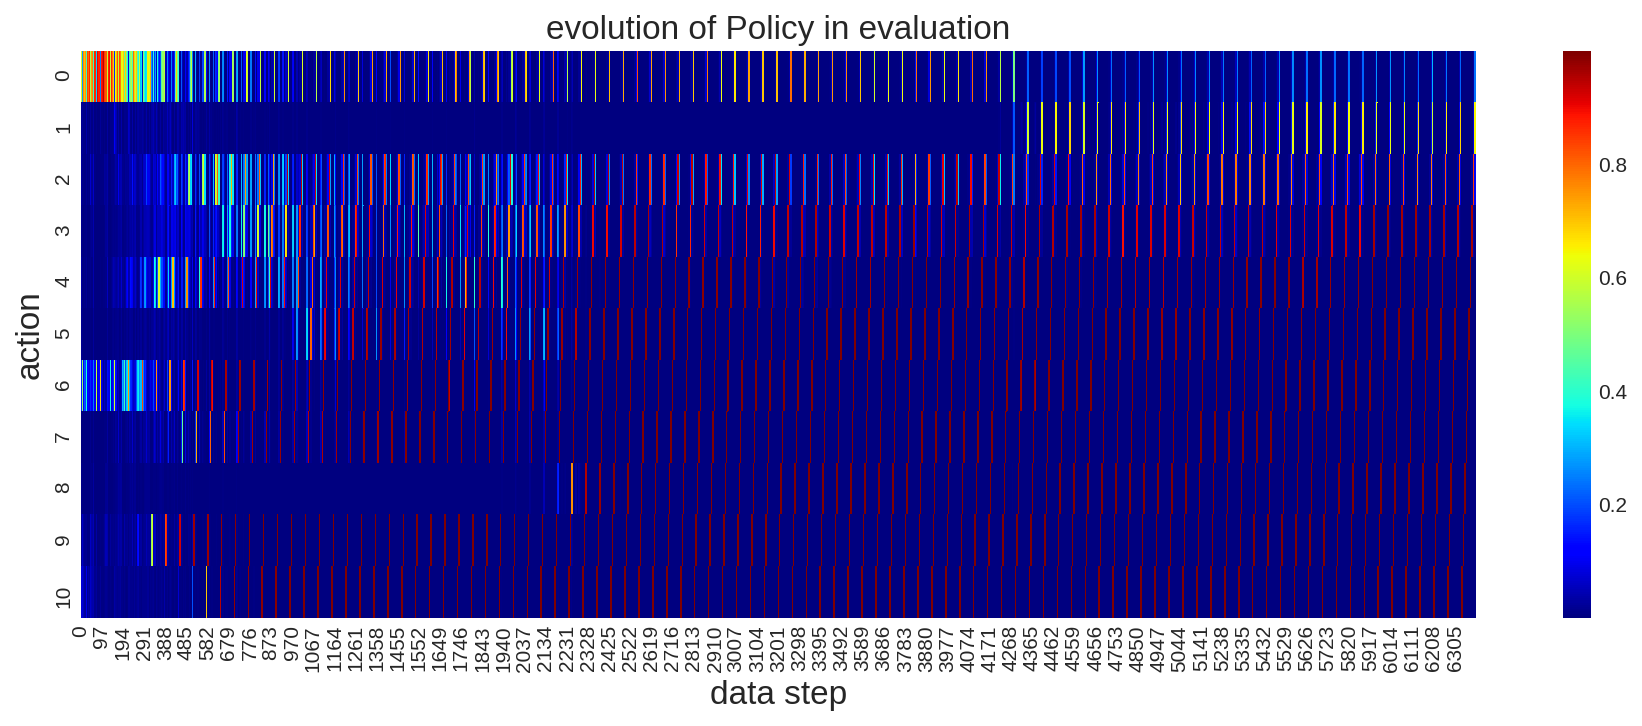

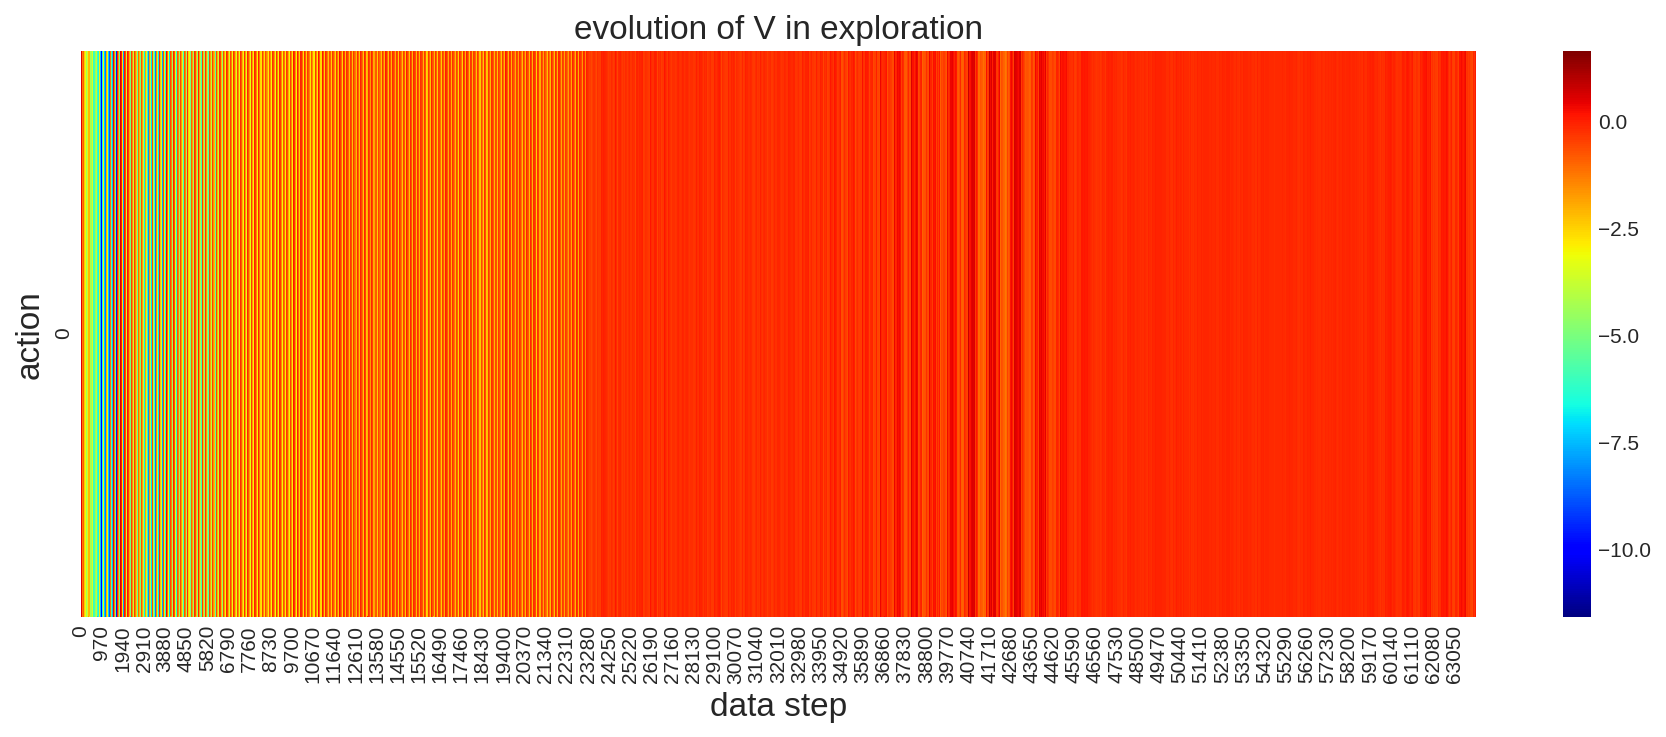

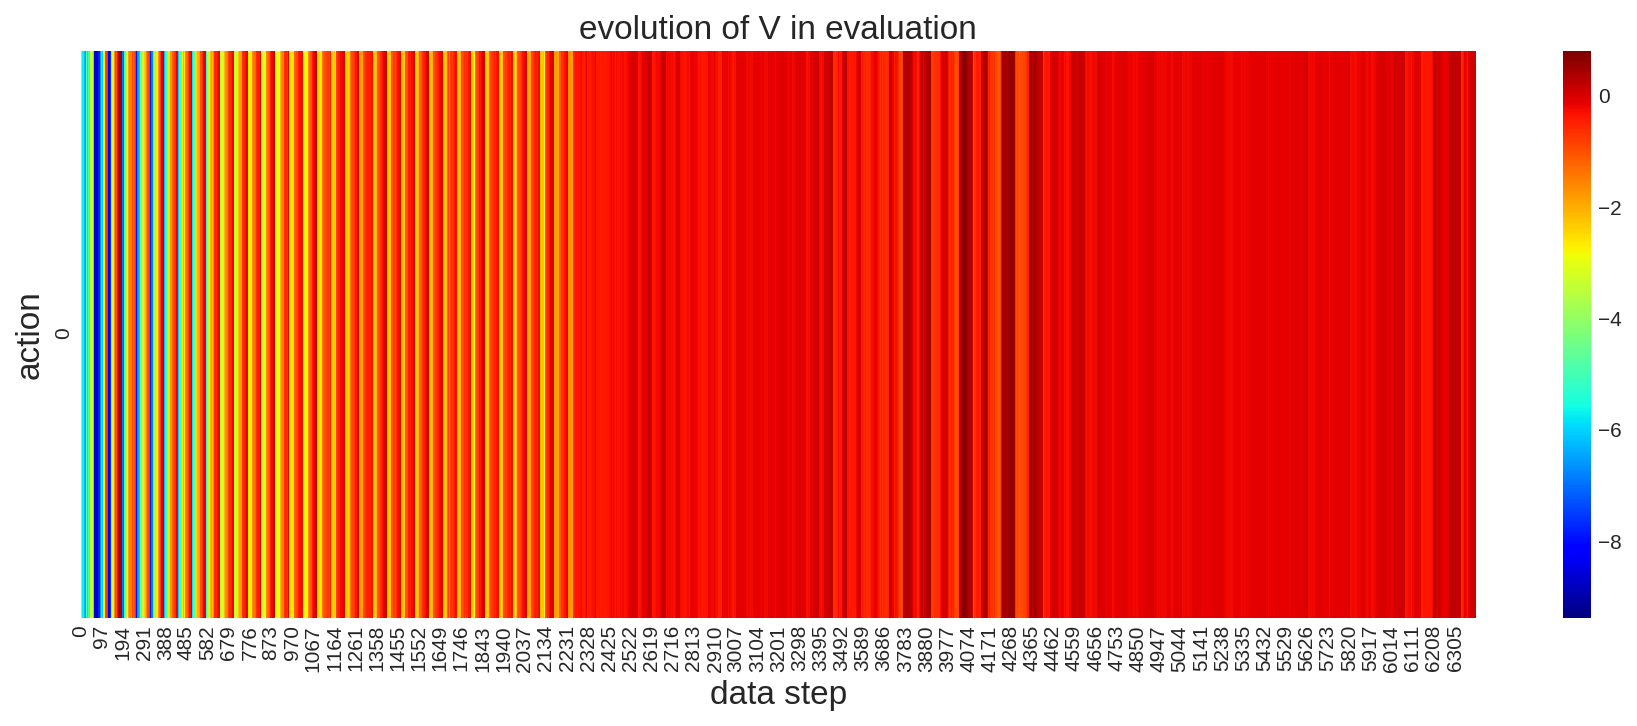

In [6]:
import A2C  # original DRL code
importlib.reload(A2C)  # original DRL code
from keras import optimizers

model = A2C.gen_model(input_shapes=env.shapes(), n_outputs=11, 
                      hidden_dims=[128, 64, 32])

#df = pd.DataFrame()
for lr, n_advantages, mult_critic, mult_entropy in itertools.product(
    [1e-3,], [4,], [0.1,], [0.1,]):
    print('======================================================')
    print('lr={}, n_advantages={}, mult_critic={}, mult_entropy={}'
          .format(lr, n_advantages, mult_critic, mult_entropy))
    
    tester = A2C.Tester(env, model)
    #n_trials = 5
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_steps=n_steps, n_advantages=n_advantages,
               gamma=1.0, optimizer=optimizers.Adam(lr=lr),
               mult_actor=1.0, mult_critic=mult_critic, mult_entropy=mult_entropy,
               verbose=False, verbose_interval=100, evaluate_interval=100, 
               get_log=True)

    viz = A2C.Visualizer()
    viz.viz_action_history(tester.trainer, lambda x:x[0], 
                           cmap='jet', alpha=1.0, s=1.0)
    viz.viz_P_history(tester.trainer)
    viz.viz_V_history(tester.trainer)

    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #f_temp['n_advantages'] = n_advantages
        #df_temp['mult_critic'] = mult_critic
        #df_temp['mult_entropy'] = mult_entropy
        df_temp['Agent'] = 'A2C_discrete'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

In [5]:
mu_min = 0.0
mu_max = 10.0

lr=0.001, n_advantages=4, mult_critic=0.1, mult_entropy=0.1
start testing... :  2019-10-30 23:18:48.852884
start 0/5 th trial...


  0%|          | 1/10000 [00:00<1:22:19,  2.02it/s]W1030 23:18:50.304575 140344548288320 deprecation.py:323] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100%|██████████| 10000/10000 [00:33<00:00, 294.55it/s]


start 1/5 th trial...


100%|██████████| 10000/10000 [00:35<00:00, 280.49it/s]


start 2/5 th trial...


100%|██████████| 10000/10000 [00:36<00:00, 273.23it/s]


start 3/5 th trial...


100%|██████████| 10000/10000 [00:37<00:00, 272.21it/s]


start 4/5 th trial...


100%|██████████| 10000/10000 [00:39<00:00, 254.89it/s]


end testing... :  2019-10-30 23:21:56.770653
loss and reward history


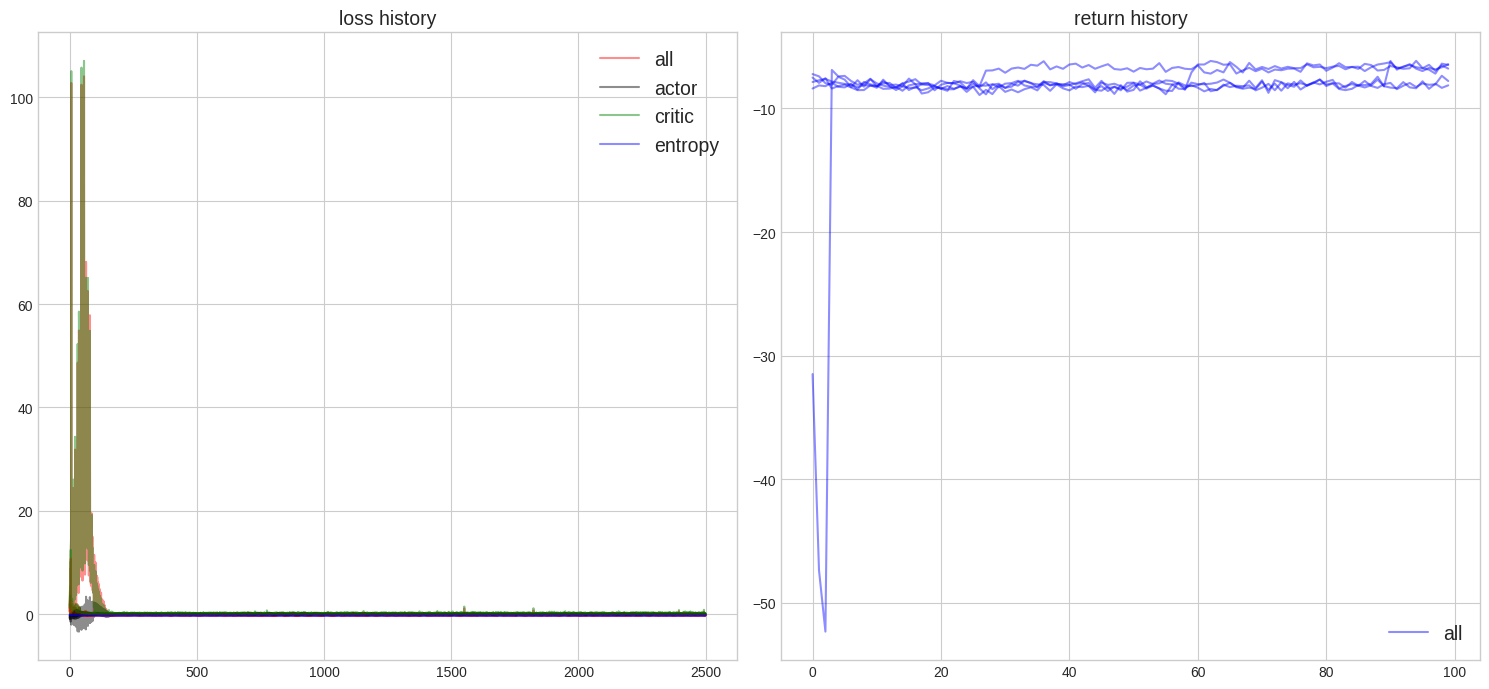

acquired action
action =  [9.99  9.988 9.99  9.988 9.988 9.99  9.988 9.99  9.989 9.988]
action =  [1.184 2.132 2.78  0.397 1.14  7.145 1.993 1.415 3.51  2.319]
action =  [1.609 2.088 2.188 0.399 1.596 2.729 2.051 1.878 2.141 2.206]
action =  [1.129 1.471 1.567 0.358 1.126 1.969 1.478 1.29  1.575 1.612]
action =  [1.699 2.182 2.175 0.577 1.69  2.803 2.223 1.961 2.268 2.29 ]
action =  [0.327 0.467 0.468 0.114 0.332 0.657 0.493 0.41  0.514 0.498]
action =  [0.435 0.569 0.562 0.217 0.45  0.759 0.604 0.508 0.582 0.595]
action =  [0.117 0.152 0.154 0.044 0.121 0.192 0.161 0.136 0.157 0.157]
action =  [0.142 0.198 0.194 0.042 0.147 0.27  0.211 0.171 0.206 0.211]
action =  [0.046 0.061 0.061 0.016 0.047 0.083 0.065 0.054 0.064 0.064]
return [-9.761 -4.509 -7.139 -9.271 -6.249 -8.524 -4.91  -5.547 -8.765 -4.814]
param distribution in model


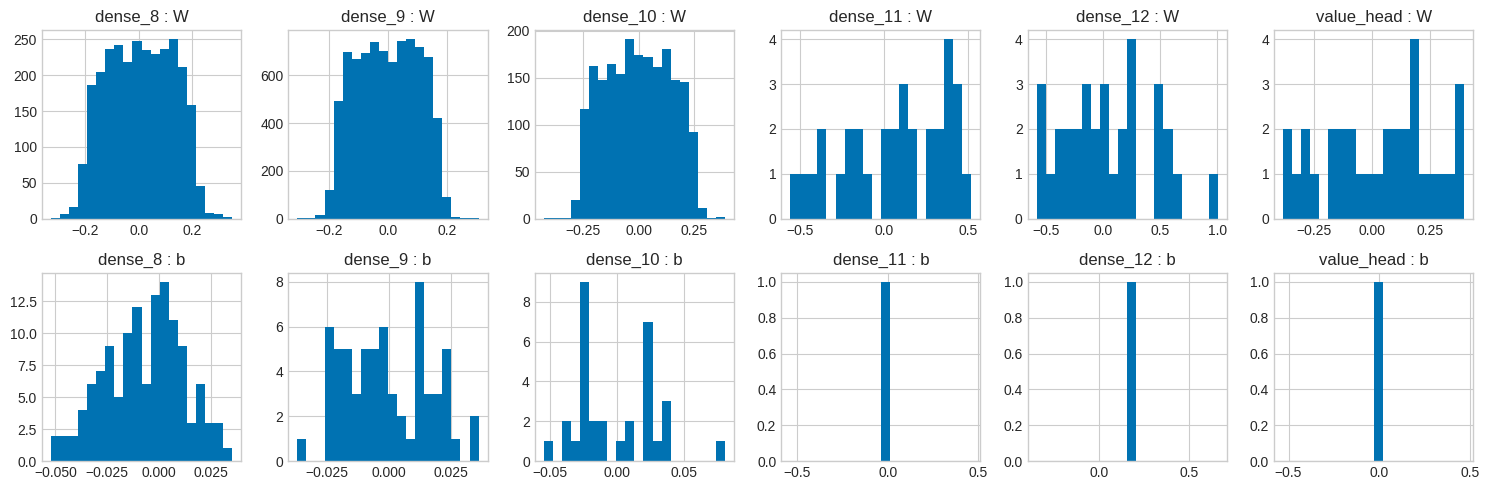

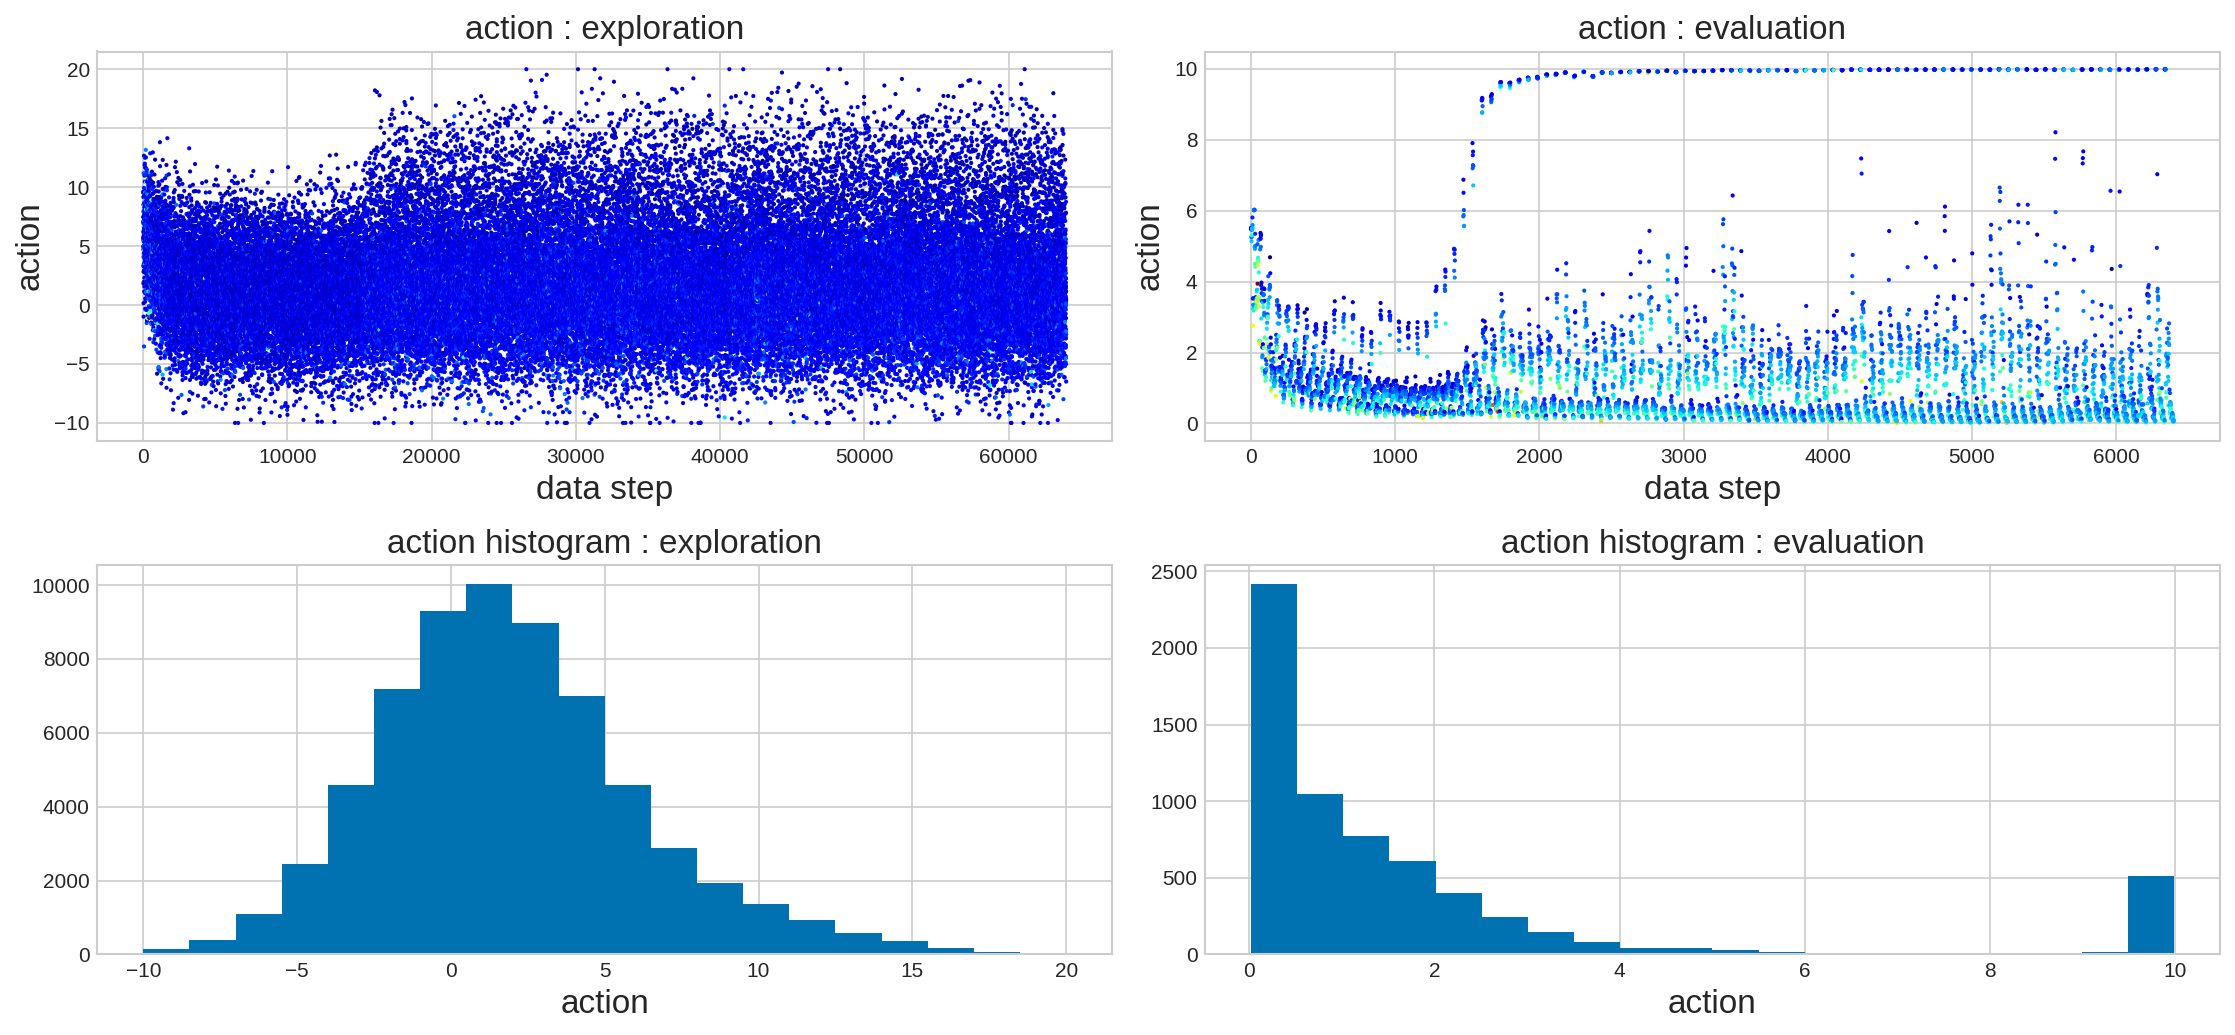

In [8]:
import importlib
import A2C_continuous
importlib.reload(A2C_continuous)  # original DRL code

from keras import optimizers

mu_min = mu_min
mu_max = mu_max
sigma_max = (mu_max - mu_min) / 3

model = A2C_continuous.gen_model(input_shapes=env.shapes(), n_outputs=1, \
                                 hidden_dims=[128, 64, 32], reg_l1=0.0, reg_l2=0.0, \
                                mu_min=mu_min, mu_max=mu_max, 
                                va_min=(0.001)**2, va_max=sigma_max**2, 
                                input_reg=False, input_min=0, input_max=1)

#df = pd.DataFrame()
for lr, n_advantages, mult_critic, mult_entropy in itertools.product(
    [1e-3,], [4,], [0.1,], [0.1,]):
    print('======================================================')
    print('lr={}, n_advantages={}, mult_critic={}, mult_entropy={}'
          .format(lr, n_advantages, mult_critic, mult_entropy))
    
    tester = A2C_continuous.Tester(env, model, val_min=mu_min-3*sigma_max, val_max=mu_max+3*sigma_max)
    #n_trials = 5
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_steps=n_steps, n_advantages=n_advantages,
               gamma=1.0, optimizer=optimizers.Adam(lr=lr),
               mult_actor=0.1, mult_critic=mult_critic, mult_entropy=mult_entropy,
               verbose=False, verbose_interval=100, evaluate_interval=100, 
               get_log=True)

    viz = A2C_continuous.Visualizer()
    viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x, 
                           cmap='jet', alpha=1.0, s=1.0)

    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #df_temp['n_advantages'] = n_advantages
        #df_temp['mult_critic'] = mult_critic
        #df_temp['mult_entropy'] = mult_entropy
        df_temp['Agent'] = 'A2C_continuous'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

lr_p=0.0001, lr_v=0.001, boltzmann=True, sigma_end=1.0, tau_end=10
start testing... :  2019-10-30 23:22:02.576539
start 0/5 th trial...


100%|██████████| 10000/10000 [04:36<00:00, 36.23it/s]


start 1/5 th trial...


100%|██████████| 10000/10000 [04:43<00:00, 25.66it/s]


start 2/5 th trial...


100%|██████████| 10000/10000 [04:52<00:00, 34.16it/s]


start 3/5 th trial...


100%|██████████| 10000/10000 [05:00<00:00, 33.31it/s]


start 4/5 th trial...


100%|██████████| 10000/10000 [05:07<00:00, 32.56it/s]


end testing... :  2019-10-30 23:46:42.464246
loss and reward history


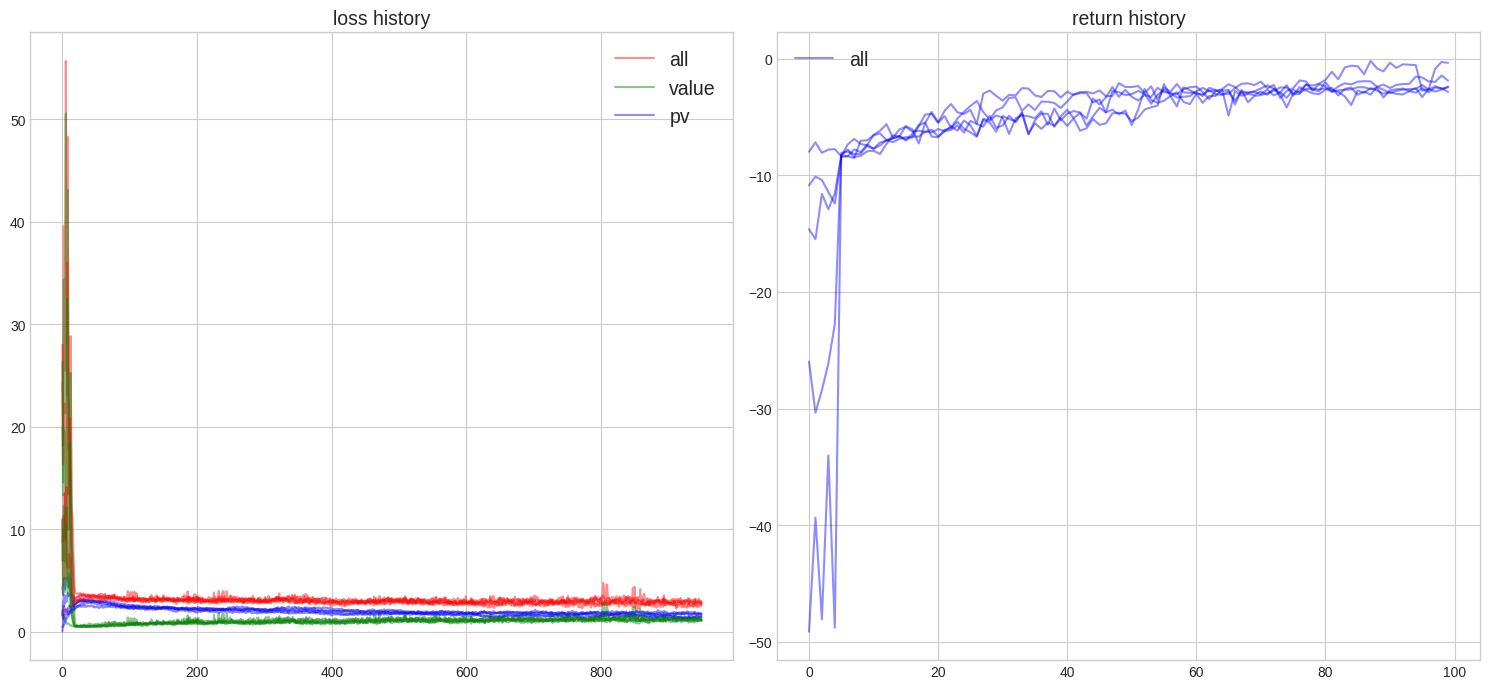

acquired action
action =  [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
action =  [9.011 9.    9.025 9.006 9.006 9.021 8.973 8.987 8.991 8.989]
action =  [7.983 8.034 7.988 8.033 7.969 7.977 7.999 8.055 7.986 7.973]
action =  [6.744 6.745 6.735 6.8   6.778 6.765 6.766 6.746 6.742 6.763]
action =  [5.939 5.945 5.945 5.963 5.994 5.994 5.956 5.944 5.962 5.936]
action =  [4.795 4.794 4.78  4.787 4.791 4.781 4.773 4.787 4.788 4.785]
action =  [3.802 3.808 3.819 3.834 3.788 3.842 3.828 3.811 3.738 3.686]
action =  [2.382 2.37  2.381 2.387 2.45  2.428 2.421 2.413 2.343 2.442]
action =  [1.871 1.869 1.868 1.873 1.9   1.915 1.877 1.888 1.871 1.89 ]
action =  [0.045 0.035 0.046 0.041 0.075 0.075 0.061 0.061 0.034 0.071]
return [-0.127 -0.36  -0.157 -0.3   -0.708 -0.772 -0.515 -0.496 -0.482 -0.666]
param distribution in model_policy


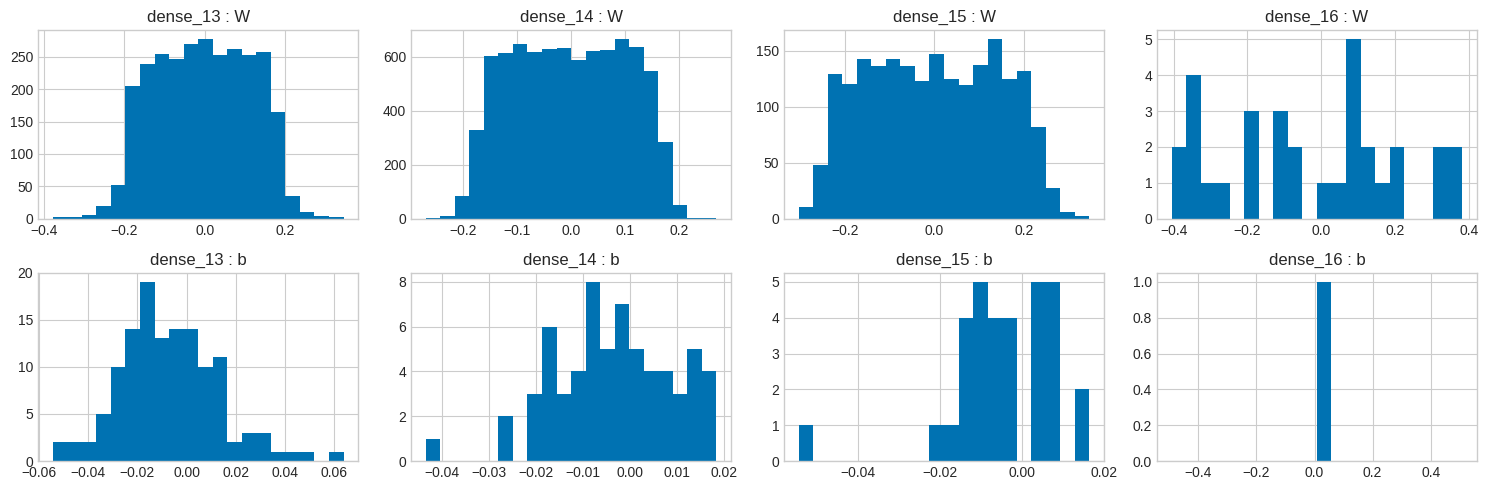

param distribution in model_value


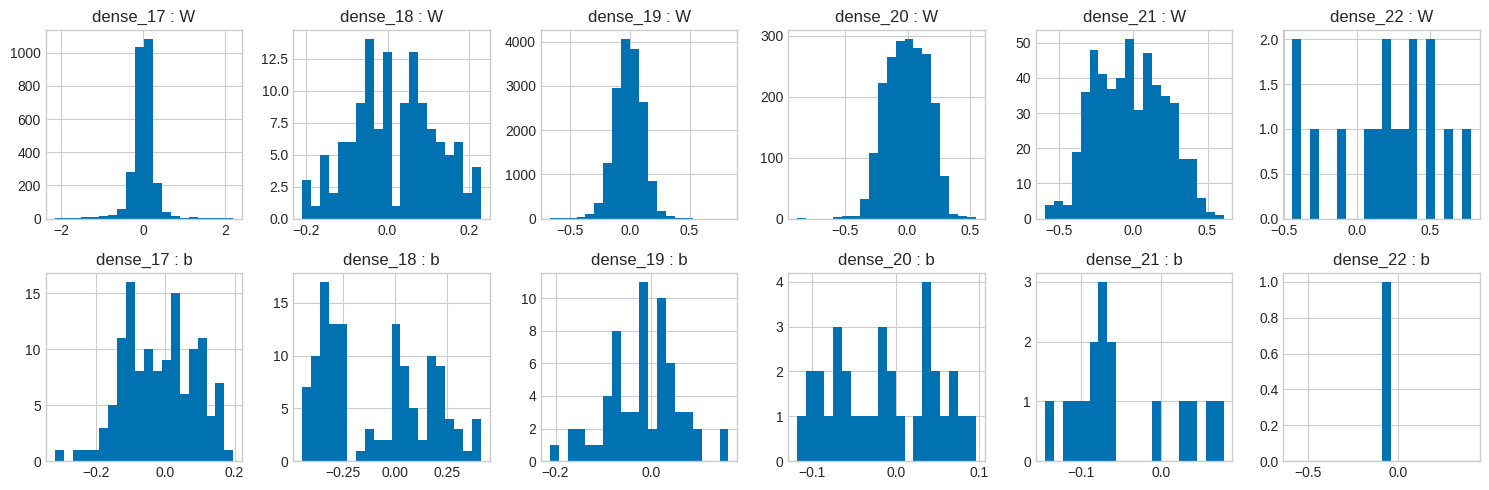

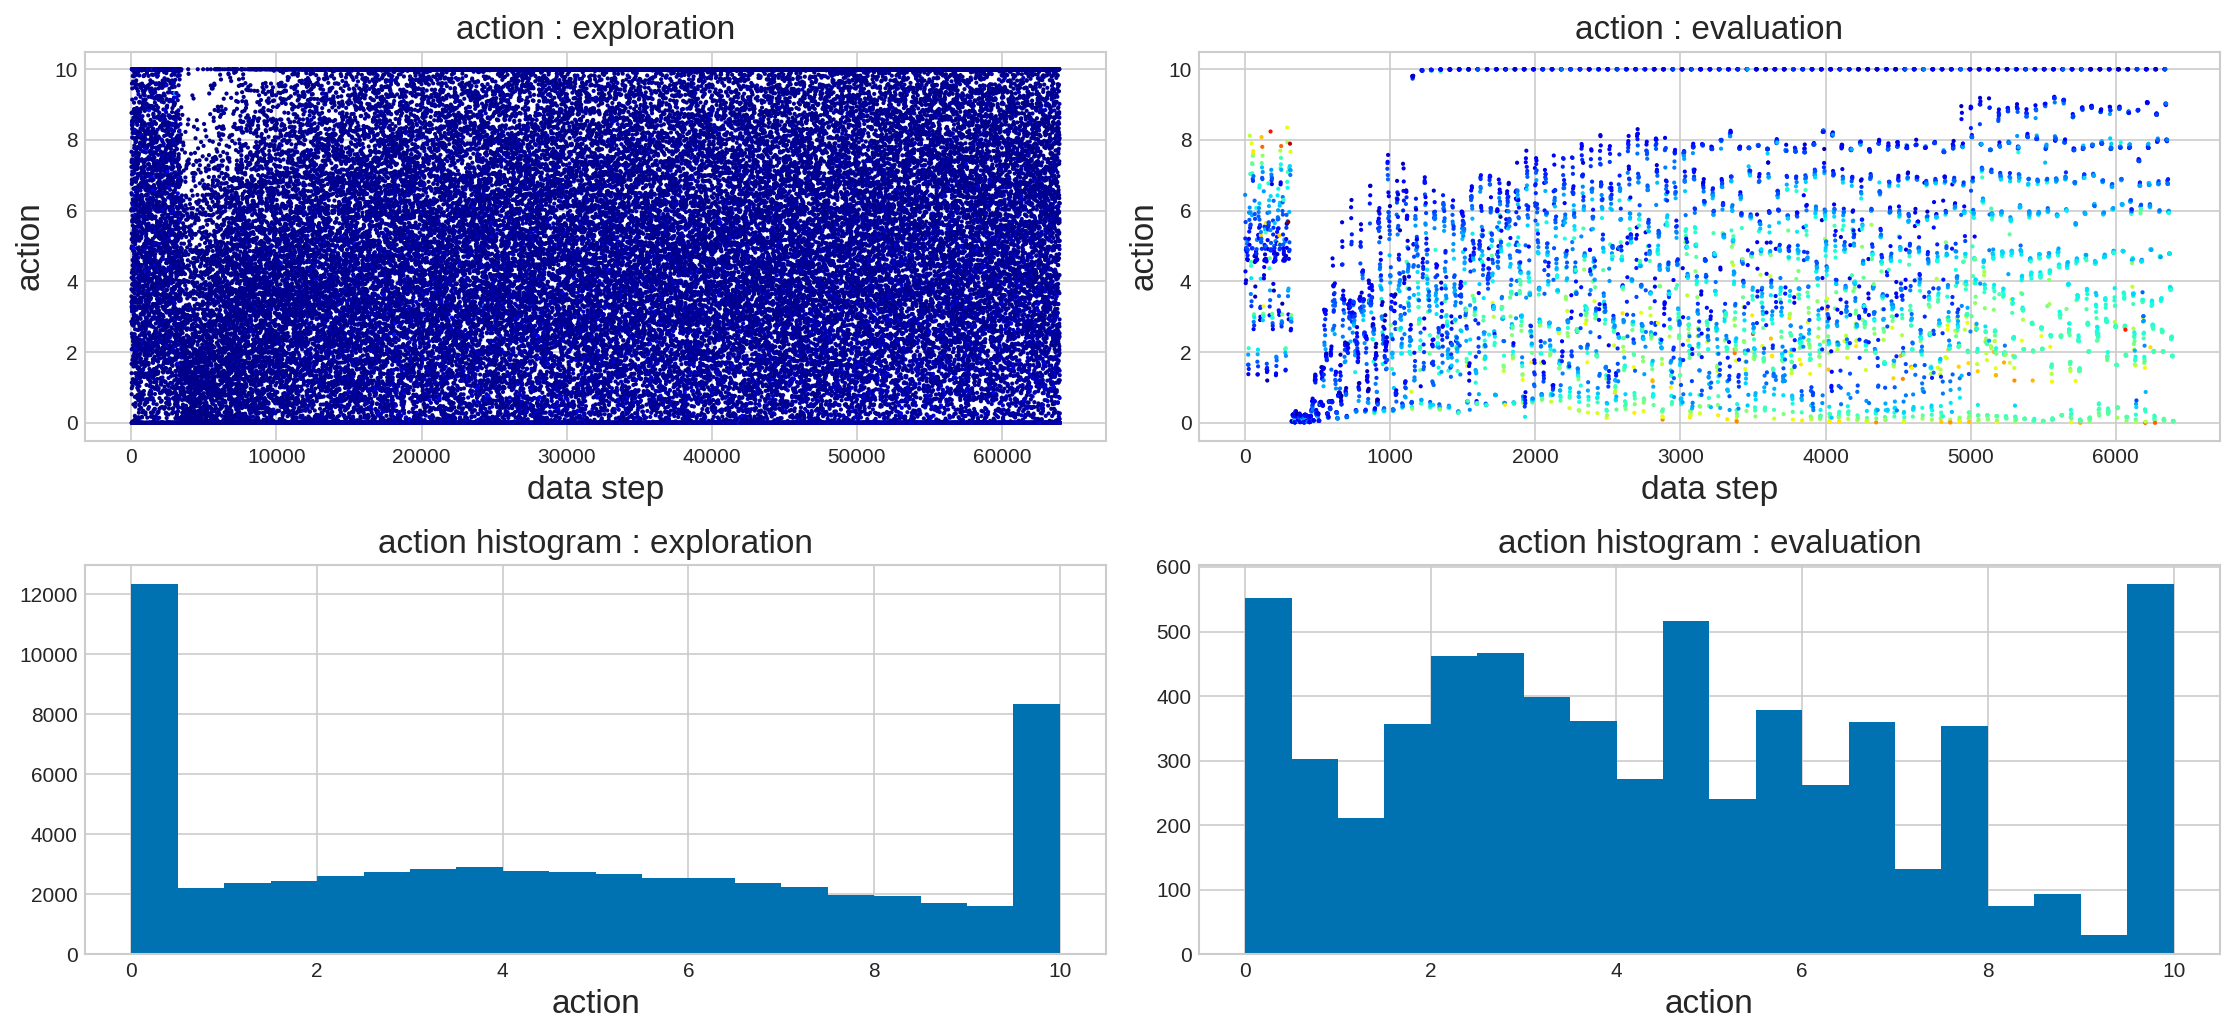

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [9]:
import DDPG  # original DRL code
importlib.reload(DDPG)
from keras import optimizers

action_min = mu_min
action_max = mu_max
sigma_max = (action_max - action_min) / 3

model_policy = DDPG.gen_model_policy(state_shapes=env.shapes(), n_actions=1, 
                                     hidden_dims=[128, 64, 32], 
                                     reg_l1=0.0, reg_l2=0.0, 
                                     action_min=action_min, action_max=action_max, 
                                     batch_norm_input=False, 
                                     state_reg=False, state_min=0, state_max=10)

model_value = DDPG.gen_model_value(state_shapes=env.shapes(), n_actions=1, \
                                   hidden_action_dims=[128,], 
                                   hidden_state_dims=[128,],
                                   hidden_dims=[64, 32, 16],
                                   reg_l1=0.0, reg_l2=0.0,
                                   batch_norm_state_hidden=False)


#df = pd.DataFrame()
for lr_p, lr_v, boltzmann, sigma_end, tau_end in itertools.product(
    [1e-4,], [1e-3,], [True,], [1.0,], [10,]):
    print('======================================================')
    print('lr_p={}, lr_v={}, boltzmann={}, sigma_end={}, tau_end={}'
          .format(lr_p, lr_v, boltzmann, sigma_end, tau_end))
    
    tester = DDPG.Tester(env, model_policy, model_value, val_min=action_min, val_max=action_max)
    #n_trials = 5
    #n_steps = 10000
    tester.test(n_trials=n_trials,
                gamma=1.0,
                n_steps=n_steps, training_interval=10, n_batches=10, batch_size=256,
                target_update_interval_policy=20, target_update_interval_value=20,
                tau_policy=0.5, tau_value=0.5,
                optimizer_pv=optimizers.Adam(lr=lr_p), optimizer_value=optimizers.Adam(lr=lr_v),
                sigma_start=sigma_max, sigma_end=sigma_max*sigma_end, sigma_interval=n_steps,
                boltzmann=boltzmann, tau_start=10, tau_end=tau_end, tau_interval=n_steps, n_samples=64,
                verbose=False, verbose_interval=100, evaluate_interval=100, 
                wampup_steps=500, 
                get_log=True)

    viz = DDPG.Visualizer()
    viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x, 
                               cmap='jet', alpha=1.0, s=1.0)
    viz.viz_Q_history(trainer=tester.trainer, 
                      state_valuation=lambda x:np.ravel(x[0][:, 0]), 
                      action_valuation=lambda x:np.ravel(x[:, 0]),
                      data_span_exp=100, data_span_eva=100,)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr_p'] = lr_p
        #df_temp['lr_v'] = lr_v
        #df_temp['boltzmann'] = boltzmann
        #df_temp['sigma_end'] = sigma_end
        #df_temp['tau_end'] = tau_end
        df_temp['Agent'] = 'DDPG'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

lr=1e-05, sigma_end=0.5
start testing... :  2019-10-30 23:46:58.135610
start trial 0/5 trial...


100%|██████████| 10000/10000 [00:53<00:00, 191.43it/s]


start trial 1/5 trial...


100%|██████████| 10000/10000 [00:55<00:00, 180.64it/s]


start trial 2/5 trial...


100%|██████████| 10000/10000 [00:56<00:00, 177.91it/s]


start trial 3/5 trial...


100%|██████████| 10000/10000 [00:58<00:00, 172.41it/s]


start trial 4/5 trial...


100%|██████████| 10000/10000 [00:58<00:00, 183.85it/s]


end testing... :  2019-10-30 23:51:50.413561
loss and return history


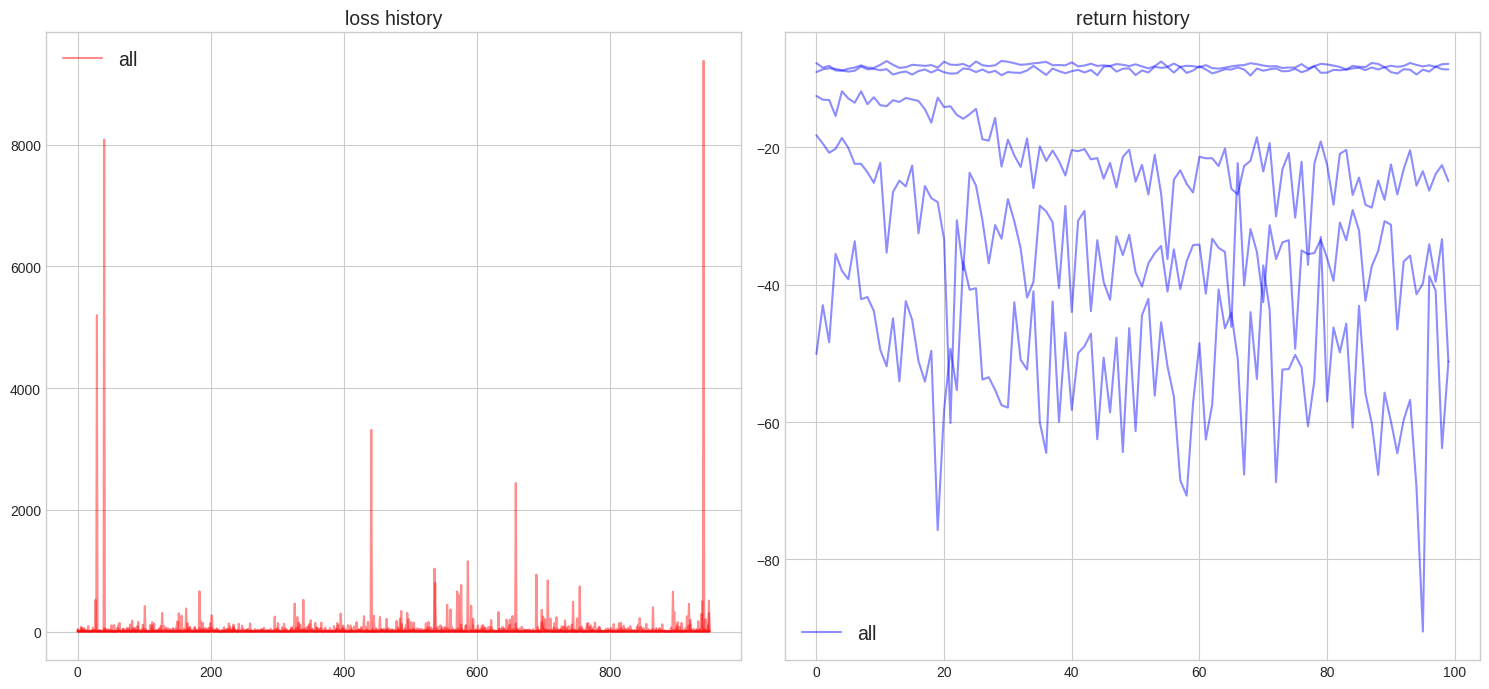

acquired action
action =  [8.699 8.629 8.544 8.624 8.614 8.471 8.758 8.721 8.671 8.635]
action =  [4.792 4.735 4.66  4.823 4.848 4.66  4.716 4.926 4.685 4.777]
action =  [5.    4.996 4.998 4.997 5.072 4.999 4.997 5.079 4.995 4.997]
action =  [4.857 4.829 4.748 4.858 5.063 4.749 4.821 4.917 4.78  4.9  ]
action =  [9.281 9.207 9.133 9.285 9.577 9.144 9.217 9.358 9.188 9.303]
action =  [9.191 9.077 8.827 9.191 9.633 8.944 9.636 9.257 9.097 9.566]
action =  [9.059 8.315 7.552 8.974 9.308 7.859 9.207 8.857 8.125 8.616]
action =  [8.25  4.956 4.916 6.403 5.792 4.938 7.472 8.668 4.981 5.521]
action =  [9.703 9.302 8.996 9.731 9.694 9.203 9.764 9.921 9.296 9.667]
action =  [9.723 4.918 4.888 7.103 6.419 4.943 8.363 8.992 4.998 7.041]
return [-71.339 -15.904 -10.035 -19.612 -24.065 -12.223 -25.024 -30.607 -11.851
 -15.647]
param distribution in model


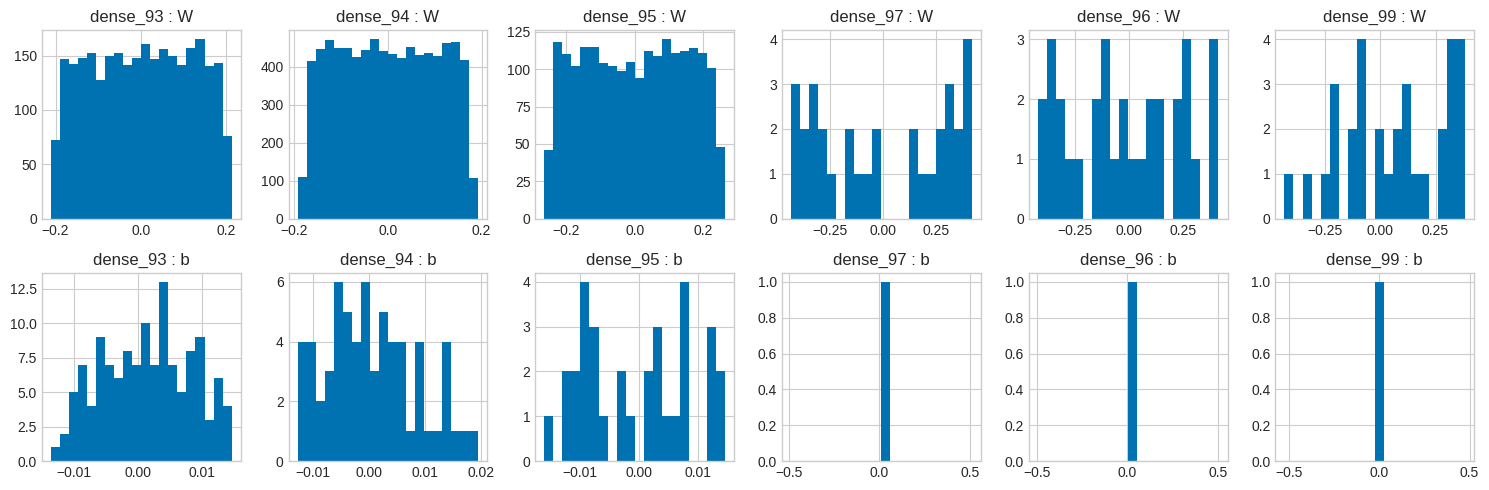

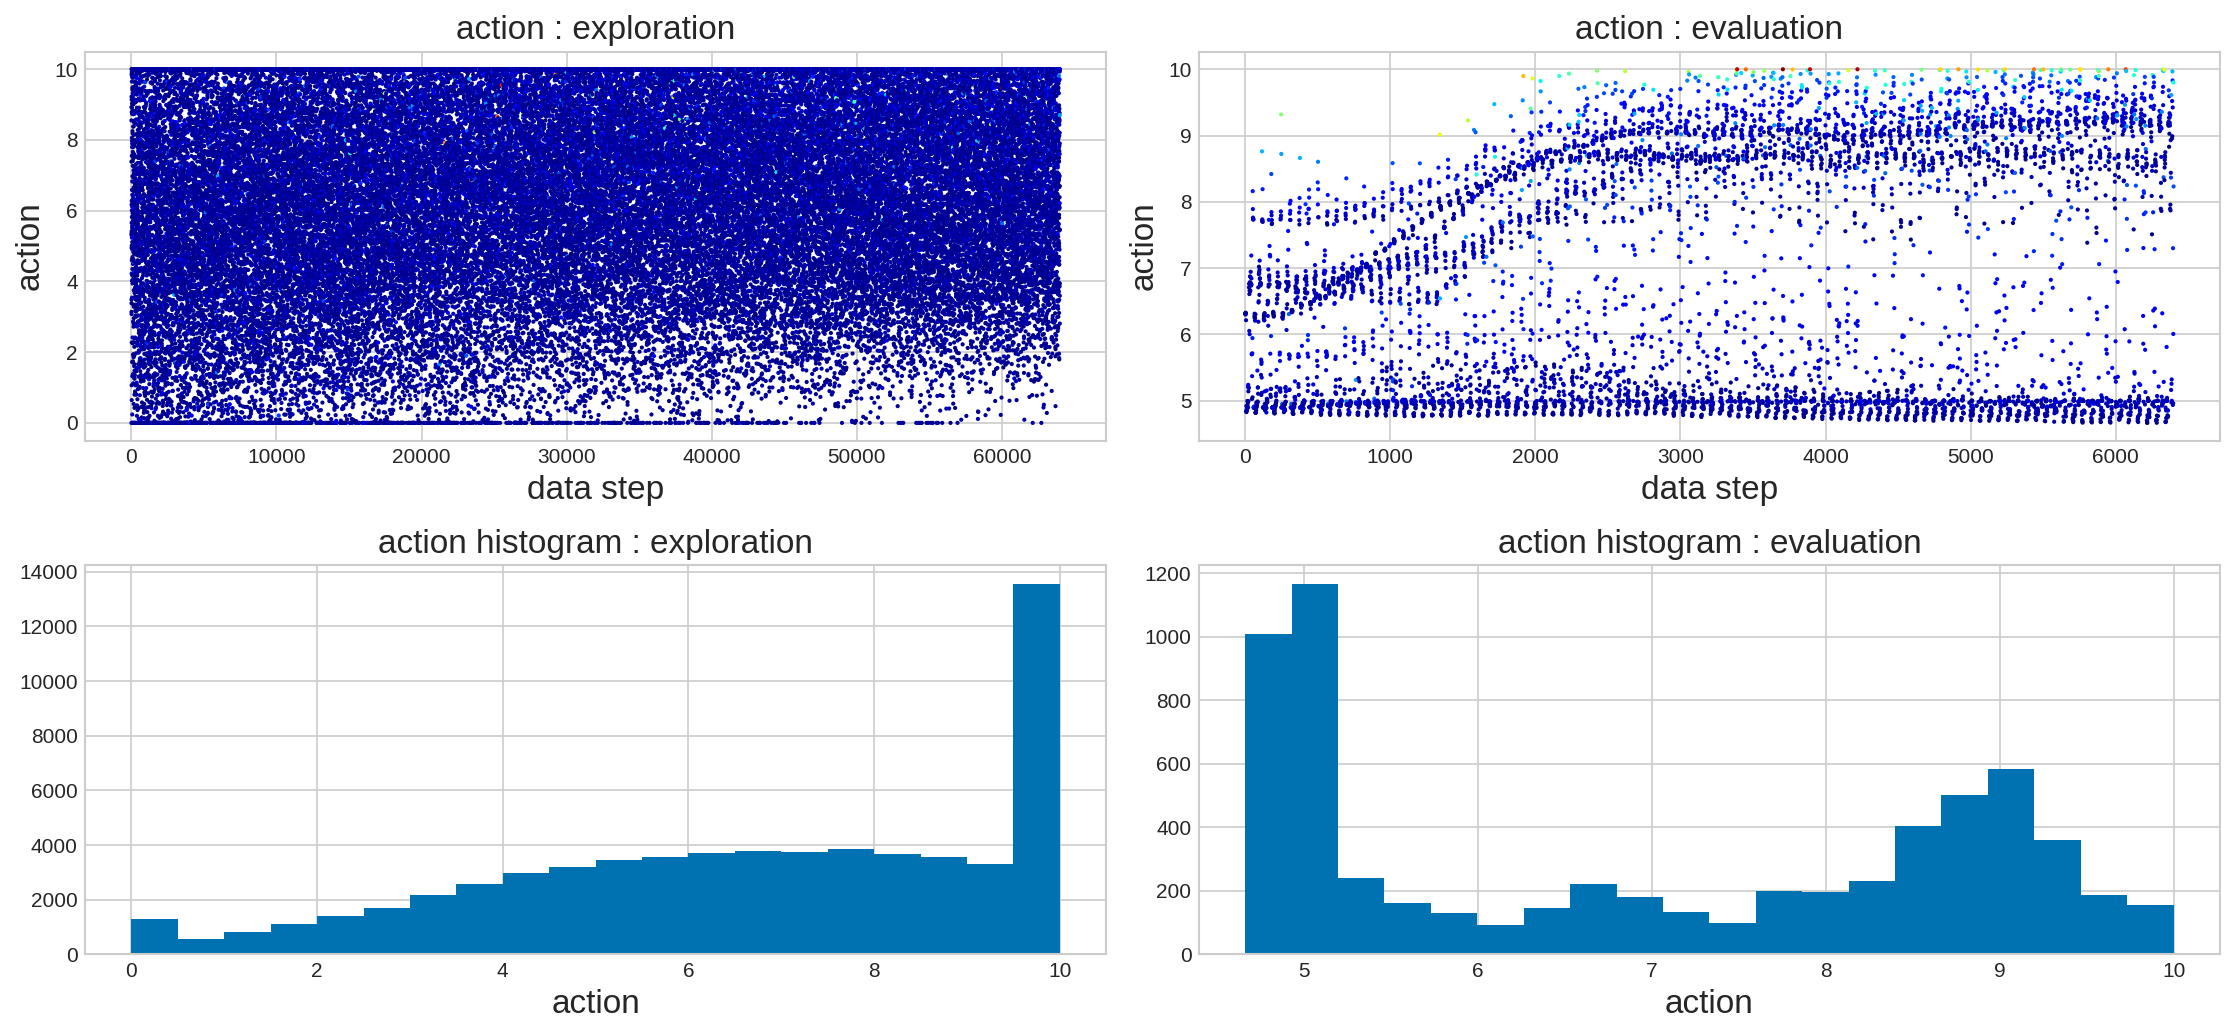

In [10]:
import NAF
importlib.reload(NAF)

from keras import optimizers
np.set_printoptions(precision=3)  # 数値桁数を指定．

action_min = mu_min
action_max = mu_max
sigma = (action_max - action_min) / 3

model_gen_func = lambda : NAF.gen_model(input_shapes=env.shapes(), n_actions=1, 
                     hidden_dims=[128, 64, 32], reg_l1=0.0, reg_l2=0.0, 
                     input_reg=False, input_min=0, input_max=10, 
                     action_reg=True, action_min=action_min, action_max=action_max,
                     value_reg=False, value_min=0, value_max=10)
model = model_gen_func()

#df = pd.DataFrame()
for lr, sigma_end in itertools.product(
    [1e-5,], [0.5,]):
    print('======================================================')
    print('lr={}, sigma_end={}'
          .format(lr, sigma_end))
    
    tester = NAF.Tester(env, model, val_min=action_min, val_max=action_max, 
                        model_gen_func=model_gen_func)
    #n_trials = 5
    #n_steps = 10000
    tester.test(n_trials=n_trials, 
                n_steps=n_steps, training_interval=10, n_batches=10, batch_size=128,
                alpha=1.0, target_update_interval=20,
                gamma=1.0,
                optimizer=optimizers.Adam(lr, clipvalue=10, clipnorm=10), 
                sigma_start=sigma, sigma_end=sigma * sigma_end, sigma_interval=n_steps,
                verbose=False, verbose_interval=100, evaluate_interval=100, 
                get_log=True)
    
    viz = NAF.Visualizer()
    viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x, 
                           cmap='jet', alpha=1.0, s=1.0)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #df_temp['sigma_end'] = sigma_end
        df_temp['Agent'] = 'NAF'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

lr=0.01, mult_critic=1.0, mult_entropy=1e-05
start testing... :  2019-10-30 23:51:55.021583
start 0/5 th trial...


100%|██████████| 10000/10000 [01:37<00:00, 103.86it/s]


start 1/5 th trial...


100%|██████████| 10000/10000 [01:38<00:00, 101.41it/s]


start 2/5 th trial...


100%|██████████| 10000/10000 [01:39<00:00, 100.26it/s]


start 3/5 th trial...


100%|██████████| 10000/10000 [01:39<00:00, 100.81it/s]


start 4/5 th trial...


100%|██████████| 10000/10000 [01:41<00:00, 98.61it/s]


end testing... :  2019-10-31 00:00:23.902709
loss and reward history


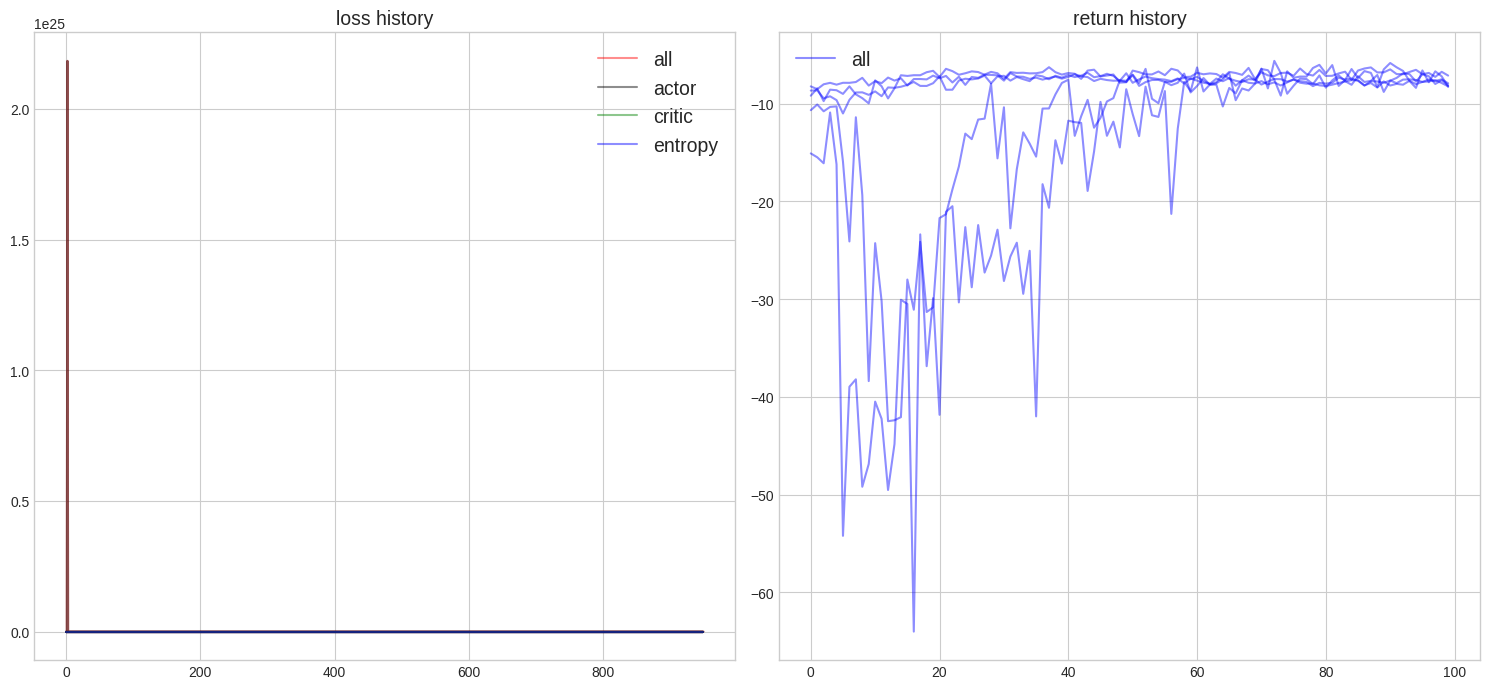

acquired action
action =  [9.969 9.95  9.959 9.955 9.949 9.931 9.961 9.943 9.929 9.97 ]
action =  [9.913 9.887 9.953 9.997 9.859 9.869 9.935 9.998 9.845 9.952]
action =  [3.08  3.28  3.055 4.304 3.38  2.885 4.526 9.49  3.122 3.57 ]
action =  [3.013 3.125 2.734 3.306 3.181 3.022 3.333 9.905 2.795 3.041]
action =  [0.011 0.01  0.007 0.045 0.012 0.012 0.116 0.104 0.011 0.017]
action =  [0.001 0.001 0.    0.012 0.001 0.001 0.011 0.373 0.    0.001]
action =  [2.980e-07 5.960e-07 0.000e+00 2.086e-06 1.192e-06 2.980e-07 5.424e-05
 2.212e-02 2.980e-07 2.980e-07]
action =  [2.682e-06 6.258e-06 2.086e-06 1.848e-05 4.768e-06 6.258e-06 1.132e-05
 2.122e-03 1.788e-06 5.662e-06]
action =  [1.490e-06 2.086e-06 2.086e-06 1.162e-05 4.470e-06 2.086e-06 1.252e-05
 3.868e-04 1.490e-06 2.086e-06]
action =  [2.980e-06 8.941e-07 1.192e-06 2.682e-06 1.192e-06 1.192e-06 2.980e-06
 8.672e-05 1.490e-06 2.086e-06]
return [ -5.274  -4.875  -5.327  -9.425  -7.205  -7.416  -9.968 -20.315  -8.782
  -5.824]
param dist

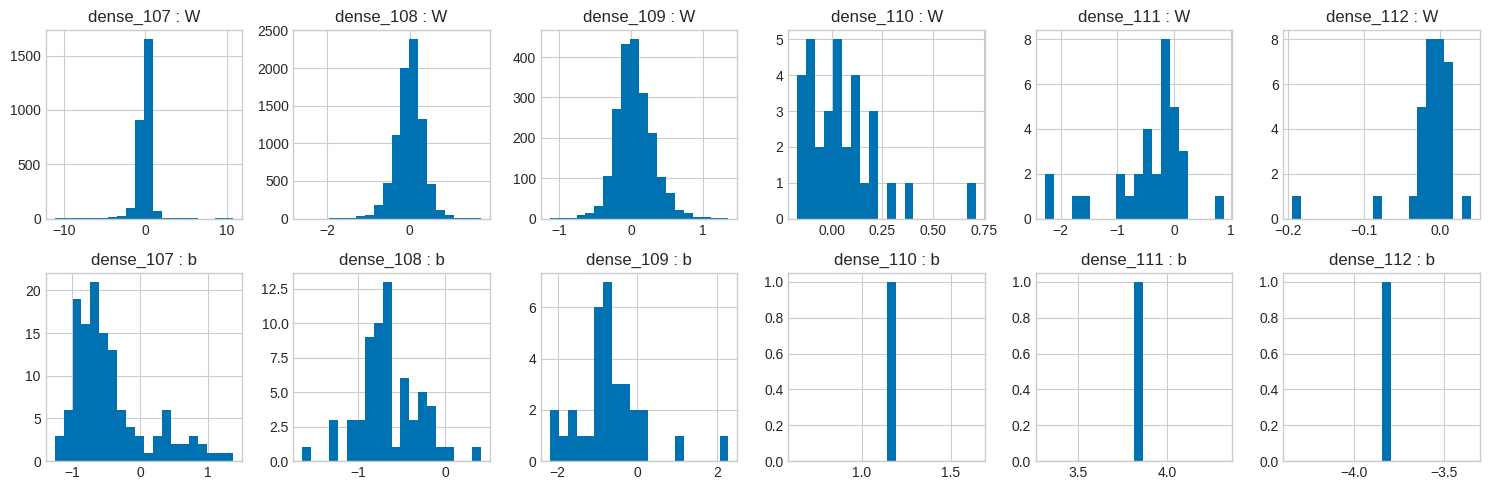

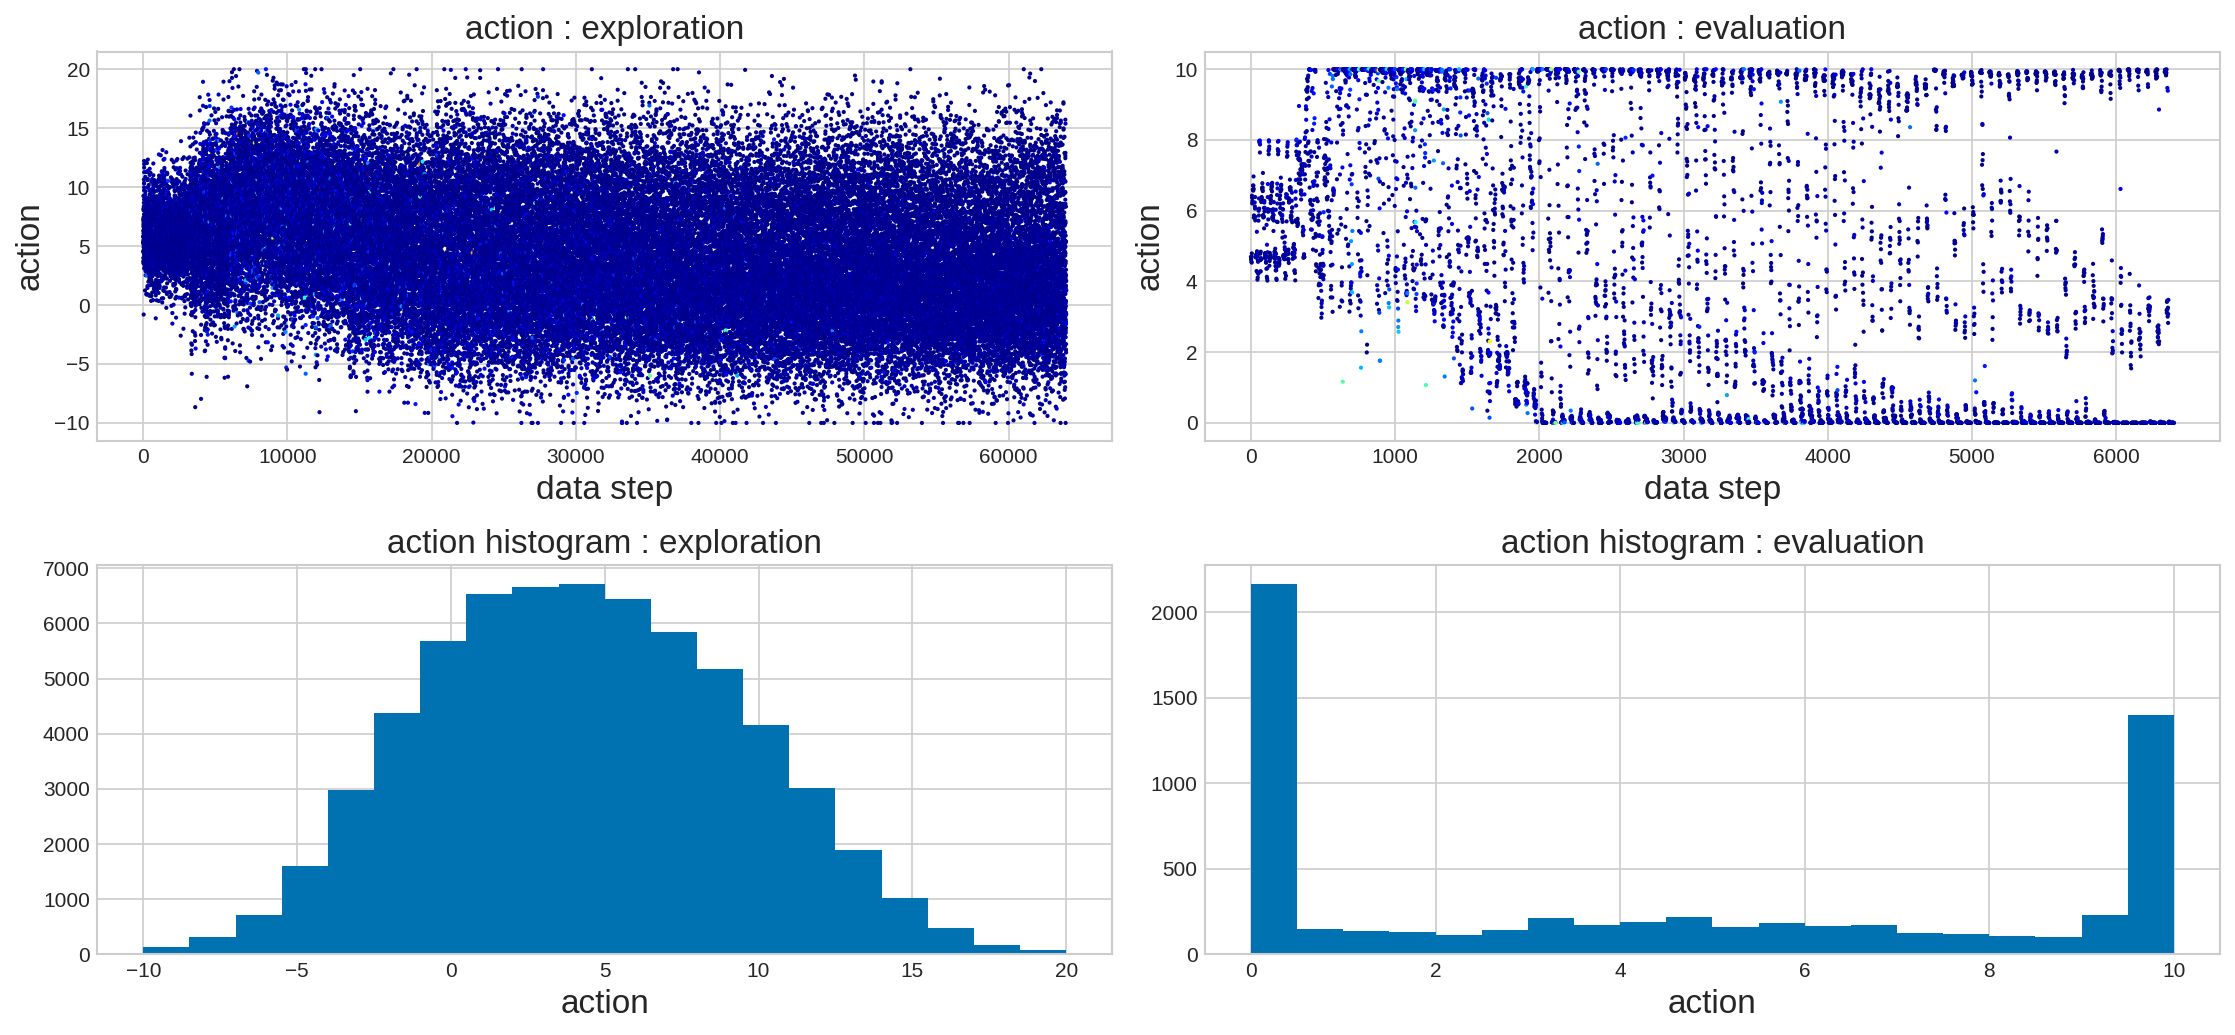

In [11]:
import AWR
importlib.reload(AWR)  # original DRL code

from keras import optimizers

mu_min = mu_min
mu_max = mu_max
sigma_max = (mu_max - mu_min) / 3

model = AWR.gen_model(input_shapes=env.shapes(), n_outputs=1, \
                      hidden_dims=[128, 64, 32], reg_l1=1e-6, reg_l2=1e-6, \
                      state_reg=False, state_min=-1.0, state_max=1.0,
                      action_reg=True, 
                      action_min=mu_min, action_max=mu_max, 
                      action_sigma_min=0.0001, action_sigma_max=sigma_max, 
                      value_reg=False, value_min=0, value_max=1)

#df = pd.DataFrame()
for lr, mult_critic, mult_entropy in itertools.product(
    [1e-2,], [1.0,], [1e-5,]):
    print('======================================================')
    print('lr={}, mult_critic={}, mult_entropy={}'
          .format(lr, mult_critic, mult_entropy))
    
    tester = AWR.Tester(env, model, 
                        action_min=mu_min-3*sigma_max, 
                        action_max=mu_max+3*sigma_max)
    #n_trials = 1
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_steps=n_steps, 
                training_interval=10, n_batches=10, batch_size=256,
                buf_alpha=0.5, buf_beta=0.5, buf_mode='rank',
                gamma=1.0, 
                optimizer=optimizers.Adam(lr=lr, clipvalue=10, clipnorm=10),
                mult_actor=1.0, mult_critic=mult_critic, mult_entropy=mult_entropy, mult_beta=10.0, 
                verbose=False, verbose_interval=100, evaluate_interval=100, 
                get_log=True)

    viz = AWR.Visualizer()
    viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x, 
                           cmap='jet', alpha=1.0, s=1.0)

    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #df_temp['mult_critic'] = mult_critic
        #df_temp['mult_entropy'] = mult_entropy
        df_temp['Agent'] = 'AWR'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

In [6]:
env = Env_DM.Environment(yield_curve, liability_CF,
                         gen_yield_on_reset=True, yield_vol=yield_vol, 
                         reset_cash=False, n_agents=64)  # stochasticの場合は並列に意味があるので64にする．

/home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
W1031 09:35:28.008992 140202341738304 deprecation_wrapper.py:119] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1031 09:35:28.025590 140202341738304 deprecation_wrapper.py:119] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1031 09:35:28.031781 

lr=0.01, eps=0.01
start testing... :  2019-10-31 09:35:28.071928
start trial 0/5 trial...


  0%|          | 0/1000 [00:00<?, ?it/s]

start trial 1/5 trial...


  0%|          | 0/1000 [00:00<?, ?it/s]

start trial 2/5 trial...


  0%|          | 0/1000 [00:00<?, ?it/s]

start trial 3/5 trial...


  0%|          | 0/1000 [00:00<?, ?it/s]

start trial 4/5 trial...


100%|██████████| 1000/1000 [19:20<00:00,  1.16s/it]


end testing... :  2019-10-31 11:11:13.556042
loss and reward history


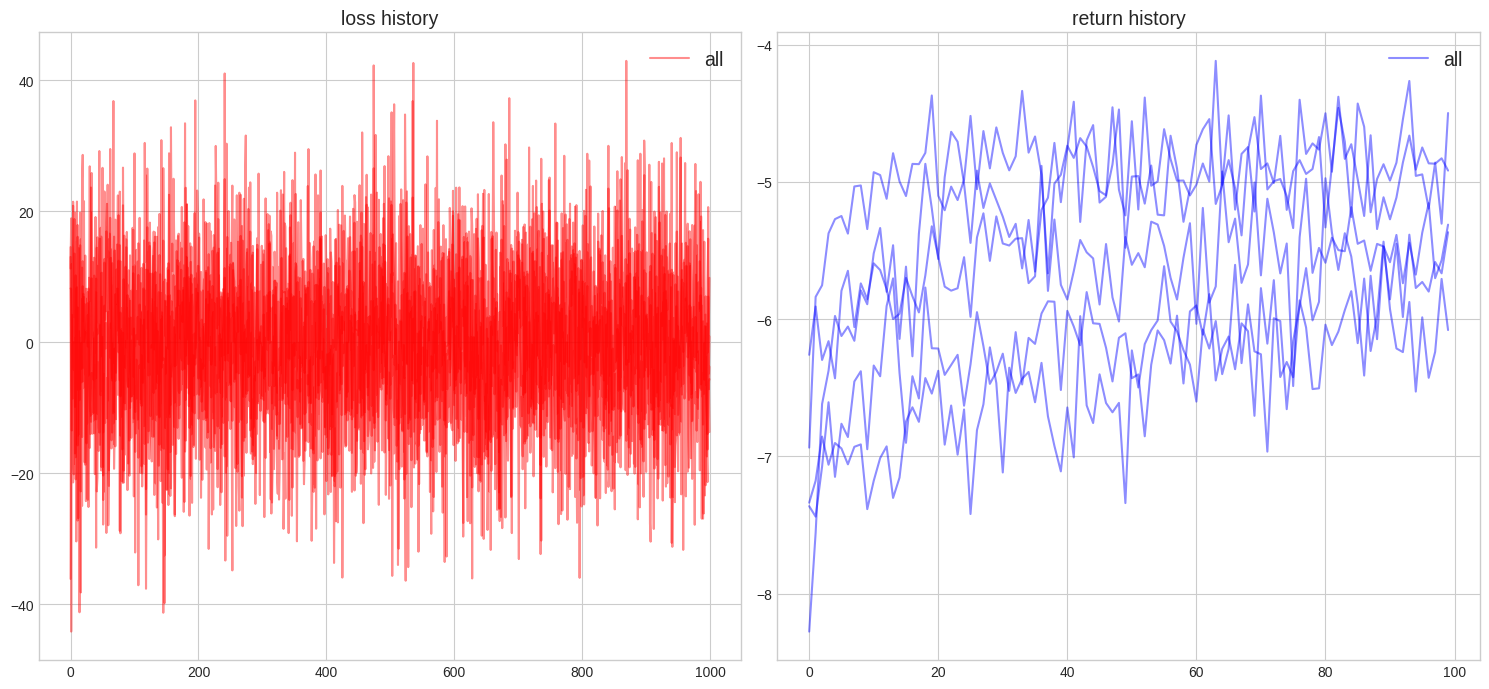

acquired action
action =  [4.693 4.044 3.835 4.084 4.803 4.797 4.092 4.227 4.316 3.642]
action =  [5.218 4.923 4.476 4.965 5.499 5.492 5.042 5.131 5.204 4.326]
action =  [4.229 4.066 3.821 4.478 4.727 4.75  4.163 4.317 4.437 3.524]
action =  [4.88  4.542 4.178 4.886 5.257 5.207 4.767 4.806 5.04  4.193]
action =  [3.807 3.708 3.555 3.933 4.044 3.951 3.722 3.858 4.03  3.591]
action =  [5.04  5.008 4.968 5.041 5.023 5.032 5.049 5.053 5.041 4.86 ]
action =  [4.028 4.034 3.894 4.023 3.991 4.035 4.015 4.022 4.019 3.831]
action =  [2.934 3.003 2.953 2.929 2.98  2.929 2.926 2.926 2.945 2.853]
action =  [2.065 1.938 1.872 2.07  2.193 2.092 2.072 2.105 2.098 1.795]
action =  [0.828 0.753 0.736 0.845 1.115 0.867 0.844 0.888 0.888 0.682]
total_reward [-3.584 -4.01  -4.871 -9.52  -5.638 -8.316 -4.293 -4.912 -5.864 -5.128]
param distribution in model


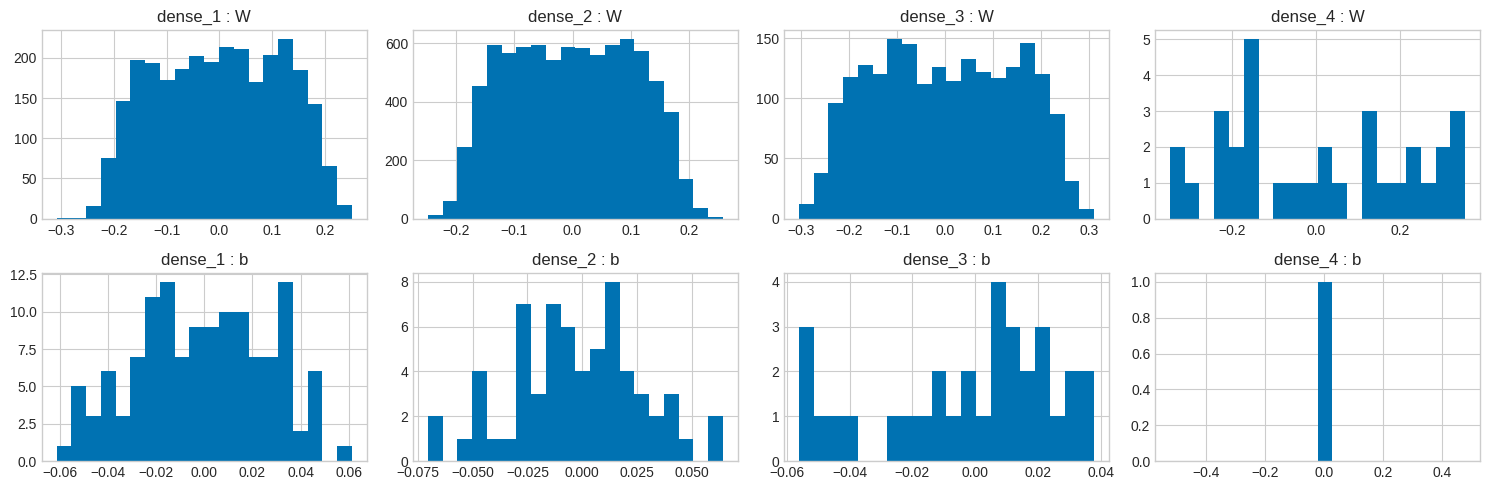

In [7]:
import ES
importlib.reload(ES)
from keras import optimizers

action_min = mu_min
action_max = mu_max

model = ES.gen_model(input_shapes=env.shapes(), n_outputs=1, \
                     hidden_dims=[128, 64, 32], reg_l1=0.0, reg_l2=0.0, \
                     action_min=action_min, action_max=action_max)

#df = pd.DataFrame()
for lr, eps in itertools.product([1e-2], [1e-2]):
    print('======================================================')
    print('lr={}, eps={}'
          .format(lr, eps))
    tester = ES.Tester(env, model, name='ES_01')
    #n_trials = 3
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_episodes=n_steps // 10, n_samples=64,
                gamma=1.0,
                learning_rate_start=lr, learning_rate_end=lr, learning_rate_interval=100,
                epsilon_start=eps, epsilon_end=eps, epsilon_interval=100,
                verbose=False, verbose_interval=100//10, evaluate_interval=100//10, 
                get_log=False)
    
    #viz = ES.Visualizer()
    #viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x,
    #                   data_span=10,
    #                   cmap='jet', alpha=1.0, s=1.0)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #df_temp['eps'] = eps
        df_temp['Agent'] = 'ES'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

er=0.5, eps=0.01
start testing... :  2019-10-31 22:48:01.047294
start trial 0/5 trial...


  0%|          | 0/1000 [00:00<?, ?it/s]

start trial 1/5 trial...


100%|██████████| 1000/1000 [19:51<00:00,  1.20s/it]


start trial 2/5 trial...


  0%|          | 0/1000 [00:00<?, ?it/s]

start trial 3/5 trial...


100%|██████████| 1000/1000 [20:11<00:00,  1.20s/it]


start trial 4/5 trial...


100%|██████████| 1000/1000 [20:12<00:00,  1.24s/it]


end testing... :  2019-11-01 00:28:18.588046
loss and reward history


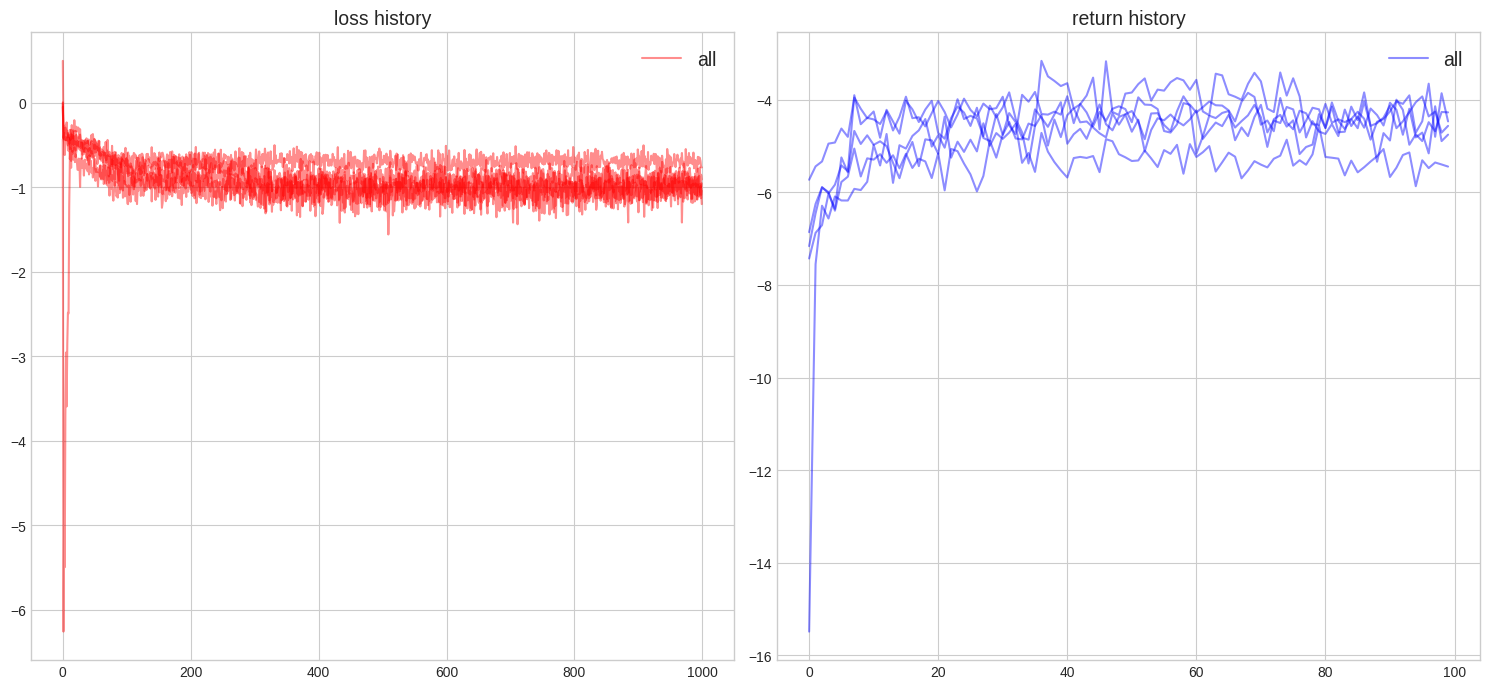

acquired action
action =  [4.935 4.355 3.397 4.203 4.87  3.901 5.276 3.785 4.255 3.629]
action =  [6.6   6.137 5.072 6.042 6.616 5.444 6.813 5.578 6.024 4.993]
action =  [7.856 7.895 8.023 7.98  7.836 8.023 7.85  7.937 7.876 8.021]
action =  [7.429 7.291 7.258 7.254 7.408 7.063 7.246 7.253 7.168 7.227]
action =  [6.06  6.231 6.107 6.042 6.098 5.994 6.187 6.025 5.891 6.19 ]
action =  [5.613 5.465 5.113 5.418 5.536 5.015 5.521 4.984 5.083 5.366]
action =  [3.619 3.852 3.731 3.84  3.641 3.537 3.854 3.617 3.543 3.727]
action =  [3.71  3.464 3.216 3.281 3.672 3.009 3.448 3.003 3.027 3.199]
action =  [2.979 2.704 2.431 2.552 2.91  2.2   2.652 2.135 2.273 2.393]
action =  [1.521 1.164 0.973 1.078 1.438 0.764 1.1   0.694 0.79  0.953]
total_reward [-6.962 -4.58  -3.681 -4.888 -5.93  -1.61  -4.309 -4.851 -1.324 -3.267]
param distribution in model


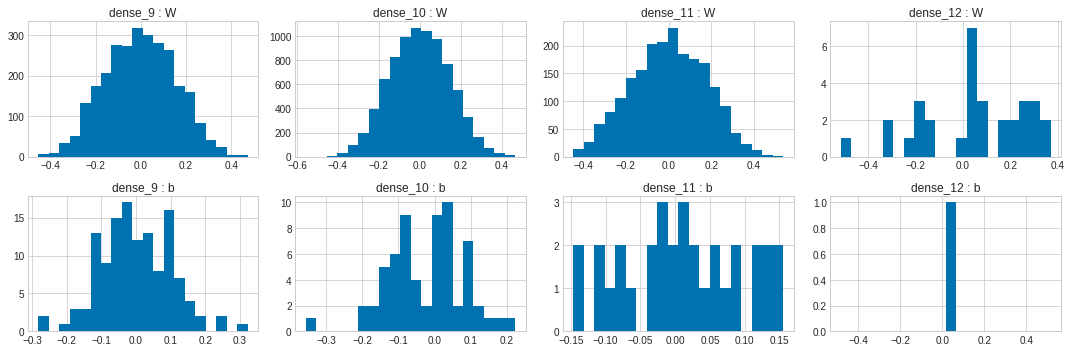

In [9]:
import GA
importlib.reload(GA)
from keras import optimizers

action_min = mu_min
action_max = mu_max

model = GA.gen_model(input_shapes=env.shapes(), n_outputs=1, \
                     hidden_dims=[128, 64, 32], reg_l1=0.0, reg_l2=0.0, \
                     action_min=action_min, action_max=action_max)

#df = pd.DataFrame()
for er, eps in itertools.product([0.5], [1e-2]):
    print('======================================================')
    print('er={}, eps={}'
          .format(er, eps))
    tester = GA.Tester(env, model, name='GA_01')
    #n_trials = 3
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_episodes=n_steps // 10, 
                n_samples=64, ratio_elite=er, 
                gamma=1.0,
                epsilon_start=eps, epsilon_end=eps, epsilon_interval=100,
                verbose=False, verbose_interval=100//10, evaluate_interval=100//10, 
                get_log=False)
    
    #viz = GA.Visualizer()
    #viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x,
    #                   data_span=1,
    #                   cmap='jet', alpha=1.0, s=1.0)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['er'] = er
        #df_temp['eps'] = eps
        df_temp['Agent'] = 'GA'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

---
## 3. Results

In [24]:
# 計算が途中で落ちたので手動結合した．
df_pre = pd.read_csv('tester_AWR.csv')
df_post = pd.read_csv('GA_01.csv')
df = pd.concat([df_pre, df_post], axis=0)

In [26]:
pd.options.display.precision = 4
ids = ['Agent',]
df[df['t'].max()*0.9<=df['t']].groupby(ids)['return'].describe()

count        mean         std         min         25%  \
Agent                                                                   
A2C_continuous   50.0 -7.2291e+00  7.5950e-01 -8.4464e+00 -7.9983e+00   
A2C_discrete     50.0 -1.5055e-14  5.4976e-16 -1.6237e-14 -1.5408e-14   
AWR              50.0 -7.3950e+00  5.7628e-01 -8.3703e+00 -7.7910e+00   
DDPG             50.0 -2.1913e+00  8.2823e-01 -3.2810e+00 -2.7333e+00   
DQN              50.0 -1.4891e-14  5.9051e-16 -1.6390e-14 -1.5172e-14   
ES               50.0 -5.4044e+00  5.3529e-01 -6.5275e+00 -5.7643e+00   
GA               50.0 -4.6214e+00  5.2856e-01 -5.8685e+00 -4.8940e+00   
NAF              50.0 -2.7880e+01  2.0852e+01 -9.0511e+01 -3.9794e+01   

                       50%         75%         max  
Agent                                               
A2C_continuous -6.8576e+00 -6.6541e+00 -6.1564e+00  
A2C_discrete   -1.5085e-14 -1.4610e-14 -1.4044e-14  
AWR            -7.5453e+00 -6.9713e+00 -5.8291e+00  
DDPG           -2.5282e+00 -1.9534e+00 -2.7286e-01  
DQN            -1.4856e-14 -1.4461e-14 -1.3933e-14  
ES             -5.3856e+00 -4.9246e+00 -4.2650e+00  
GA             -4.5905e+00 -4.2187e+00 -3.6548e+00  
NAF            -2.3687e+01 -8.6447e+00 -7.7278e+00

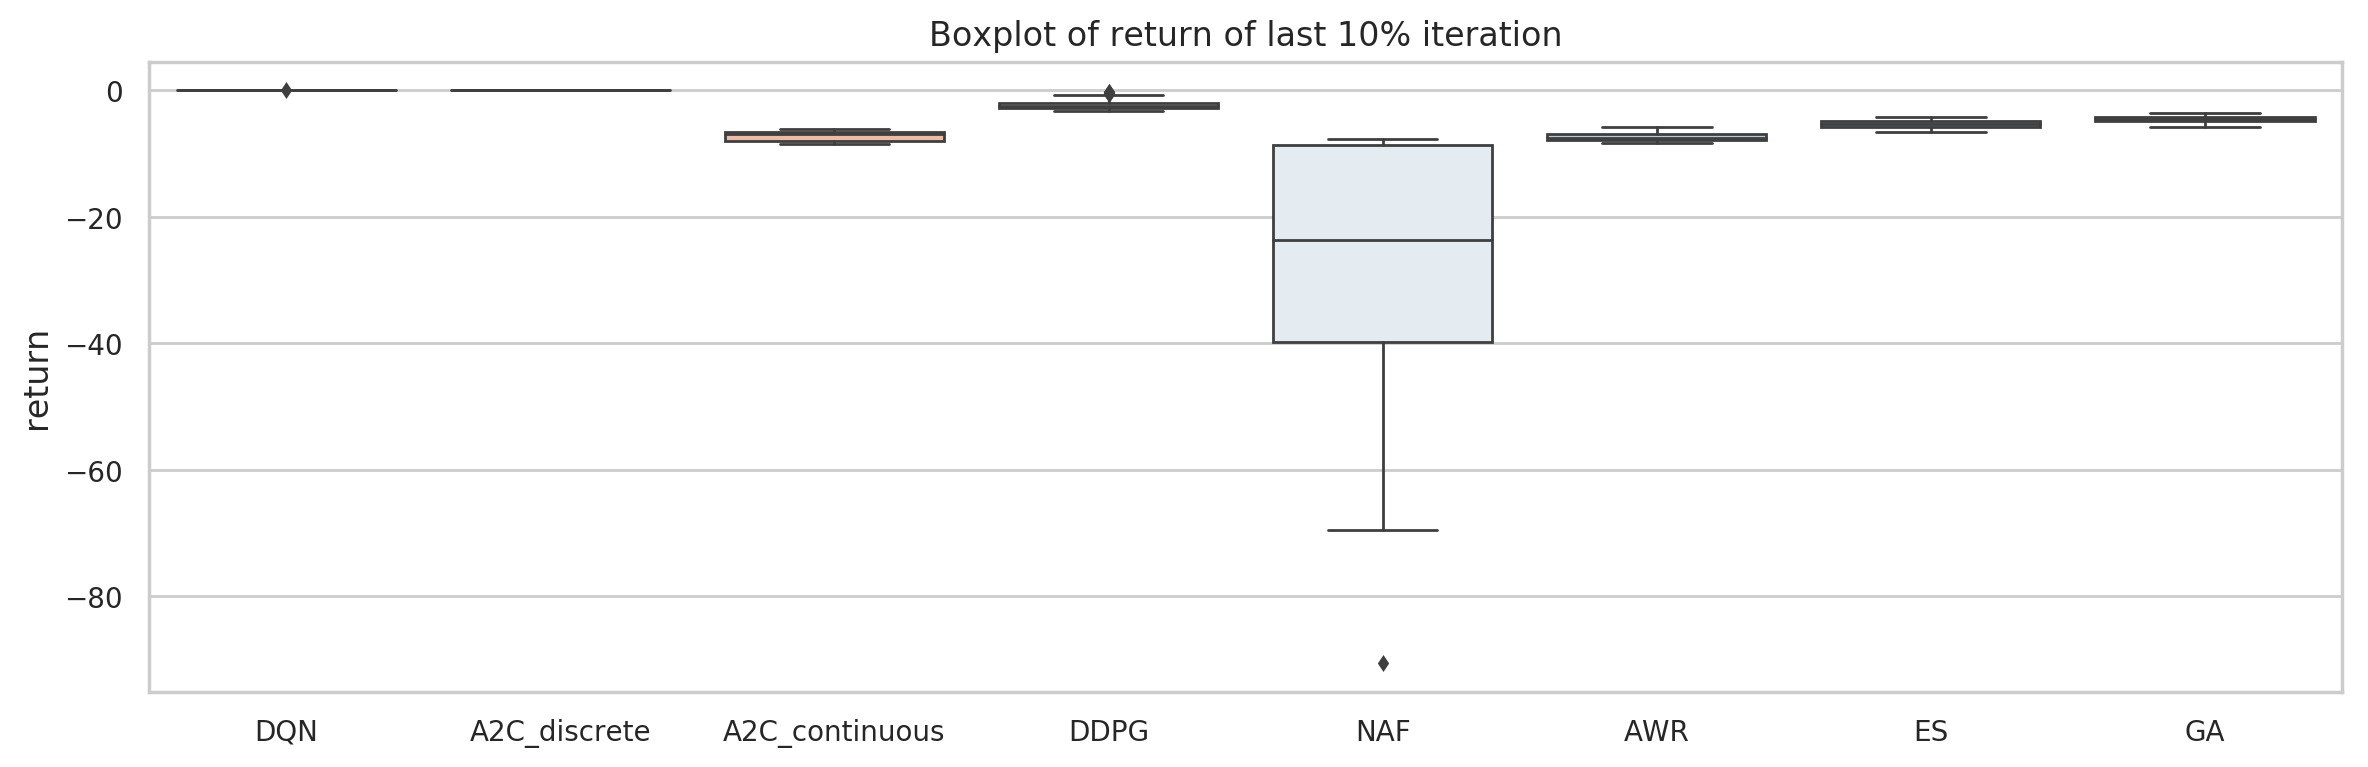

In [27]:
sns.set_style("whitegrid")
sns.set_context("notebook")

plt.figure(figsize=(12, 4), dpi=200)

sns.boxplot(data=df[df['t'].max()*0.9<=df['t']], x='Agent', y='return', orient='v', fliersize=3.0, linewidth=1.0, palette='RdBu')

plt.title('Boxplot of return of last 10% iteration', fontsize=12)
plt.xlabel('', fontsize=12)
plt.ylabel('return', fontsize=12)
plt.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

/home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


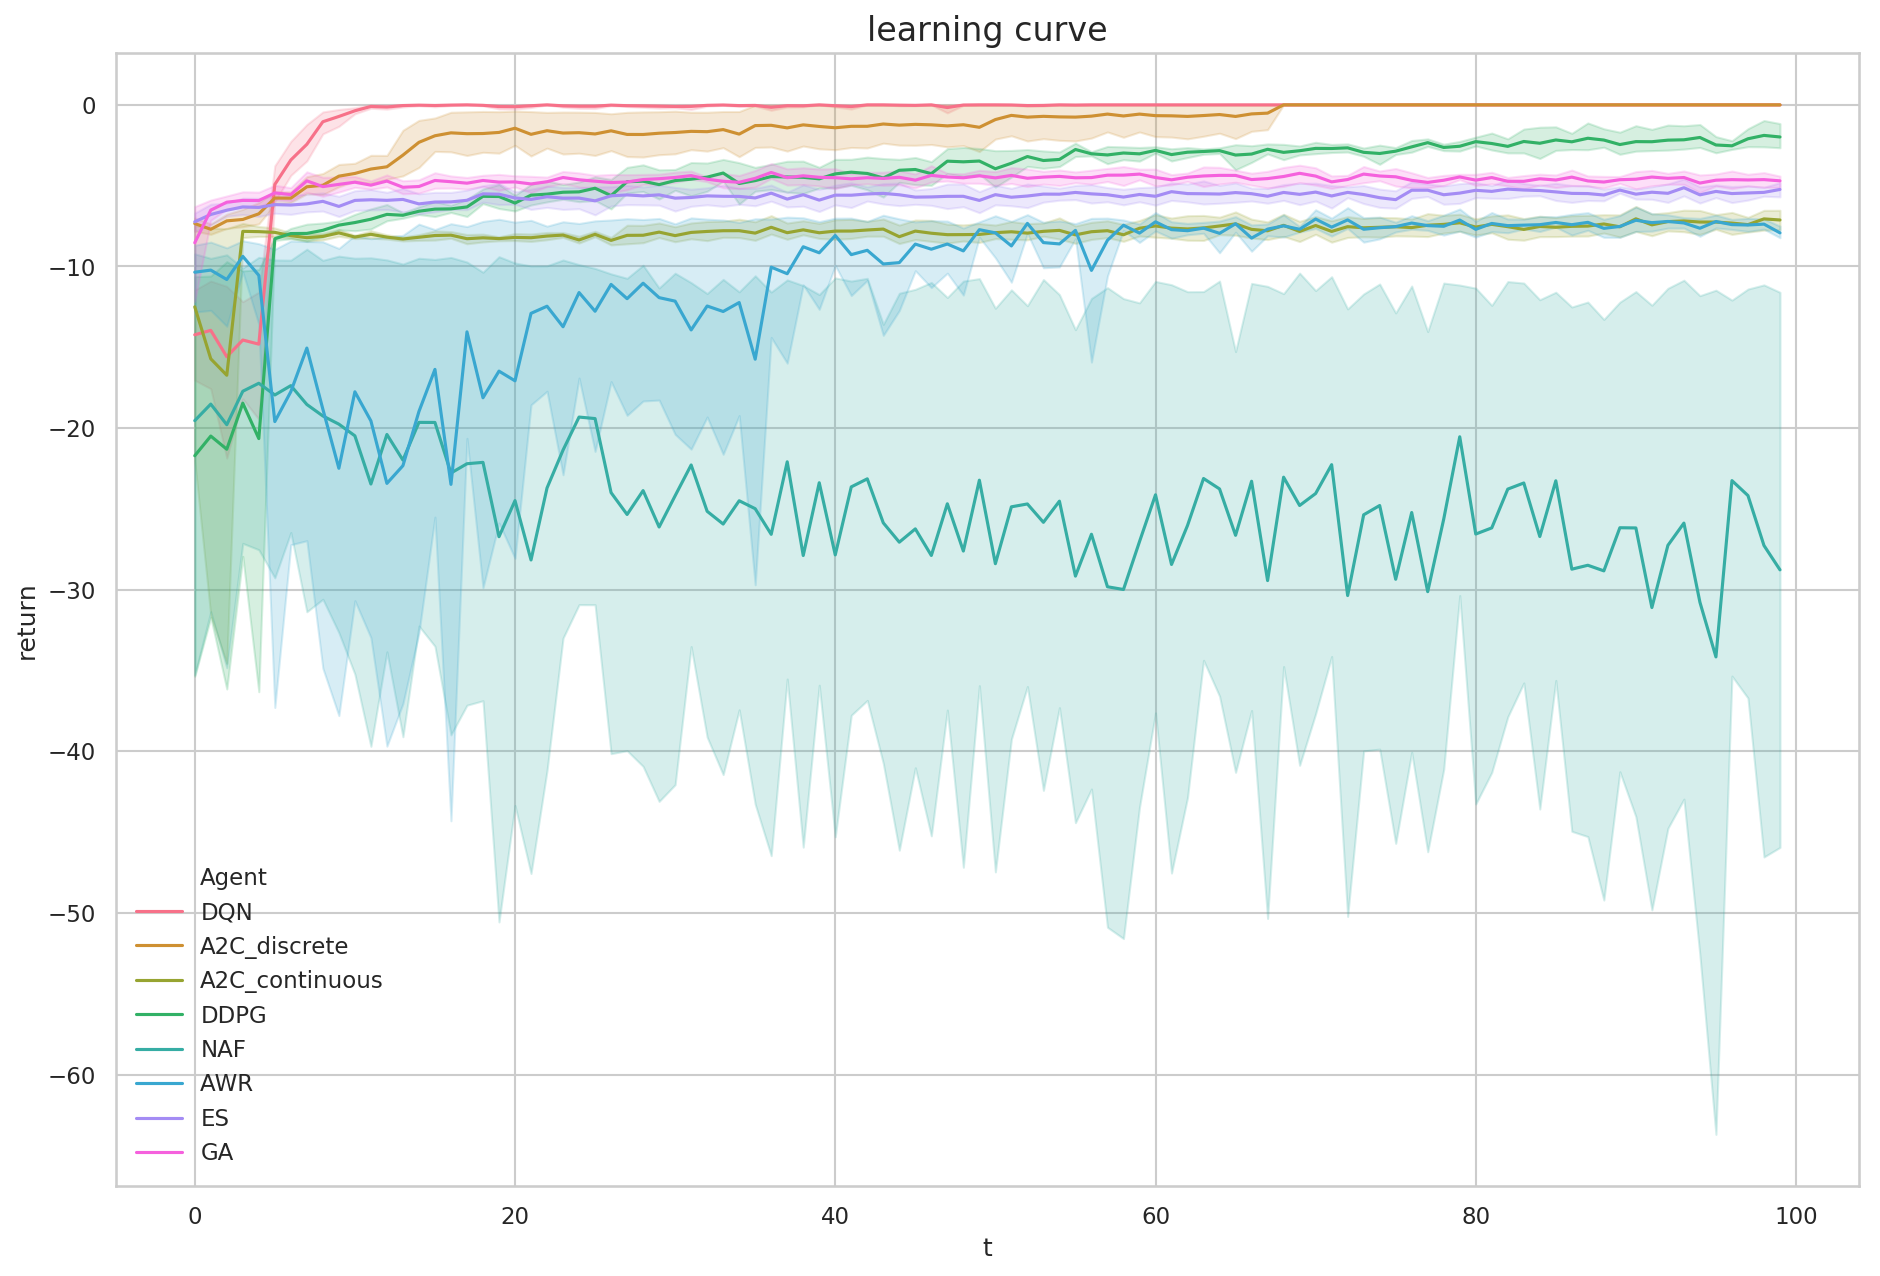

In [28]:
fig = plt.figure(figsize=(15, 10), dpi=150)
sns.lineplot(x='t', y='return', hue='Agent', data=df)
plt.title('learning curve', size=16)
plt.show()